# Differential Privacy in Machine Learning

This notebook demonstrates the process of applying differential privacy techniques to a dataset, specifically for use in machine learning algorithms such as SVM, Neural Networks, and Decision Tree. The goal is to assess the effect of different variations and magnitudes of noise on these algorithms. Noise mechanisms applied and explored include Laplace, Exponential and Gaussian.


In [1]:
# Importing in the necessary libraries and tools required to apply and analyse differential privacy techniques.

import numpy as np
import pandas as pd
from scipy.stats import laplace, norm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score
from sklearn.metrics import accuracy_score, precision_recall_curve, precision_score, recall_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
import opacus 
from torch.utils.data import DataLoader, TensorDataset
from autodp.calibrator_zoo import eps_delta_calibrator,generalized_eps_delta_calibrator, ana_gaussian_calibrator
from autodp import rdp_bank
from autodp.mechanism_zoo import GaussianMechanism, LaplaceMechanism
from autodp.transformer_zoo import Composition, AmplificationBySampling
import torch
import torch.nn as nn
import torch.optim as optim
from tensorflow.keras.optimizers import SGD
from scipy.stats import gaussian_kde
from scipy.stats import entropy
from scipy.stats import ks_2samp
from tabulate import tabulate
from IPython.display import display





%matplotlib inline

## Dataset Overview

The dataset used in this analysis is an insurance dataset which contains features such as age, sex, bmi, children, smoker, region, and charges. The dataset includes sensitive information about participants which they may not want revealed or traced back. The aim is to add noise to this dataset in a variety of ways to implement differential privacy and analyse the impacts of each method.


In [2]:
# Loading in the required Dataset
dataset = pd.read_csv('insurance.csv')
dataset.dropna(inplace=True)
dataset


age     sex     bmi  children smoker     region      charges
0      19  female  27.900         0    yes  southwest  16884.92400
1      18    male  33.770         1     no  southeast   1725.55230
2      28    male  33.000         3     no  southeast   4449.46200
3      33    male  22.705         0     no  northwest  21984.47061
4      32    male  28.880         0     no  northwest   3866.85520
...   ...     ...     ...       ...    ...        ...          ...
1333   50    male  30.970         3     no  northwest  10600.54830
1334   18  female  31.920         0     no  northeast   2205.98080
1335   18  female  36.850         0     no  southeast   1629.83350
1336   21  female  25.800         0     no  southwest   2007.94500
1337   61  female  29.070         0    yes  northwest  29141.36030

[1338 rows x 7 columns]

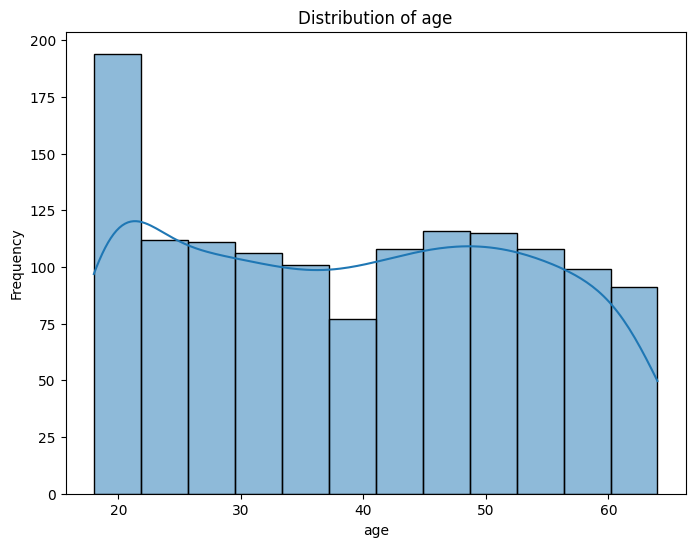

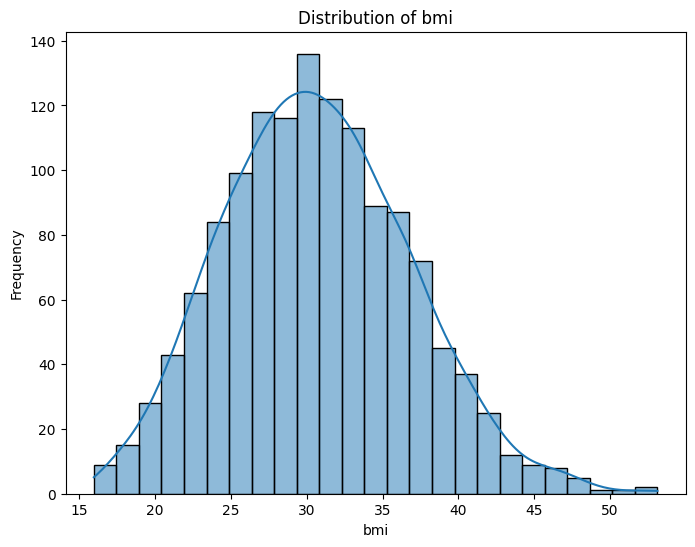

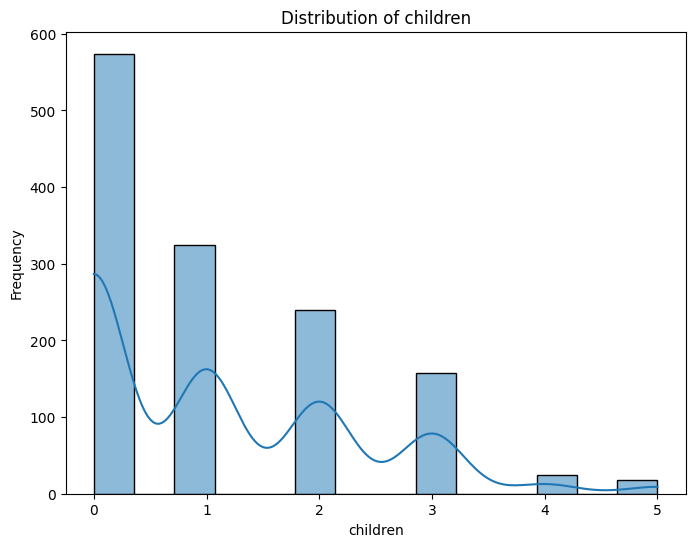

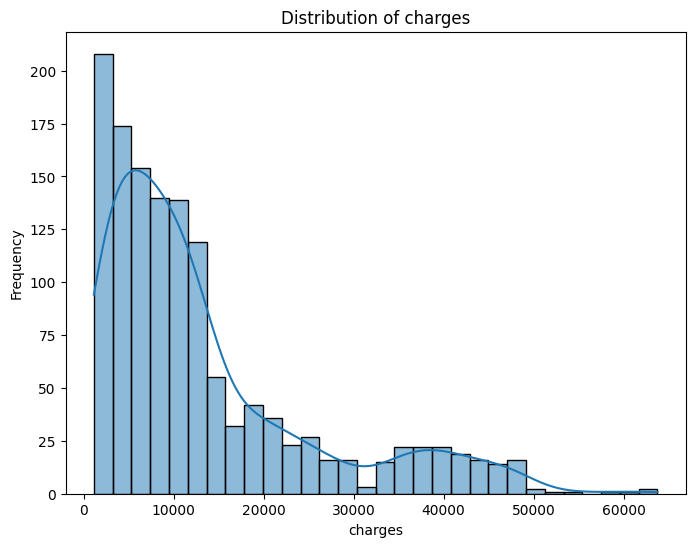

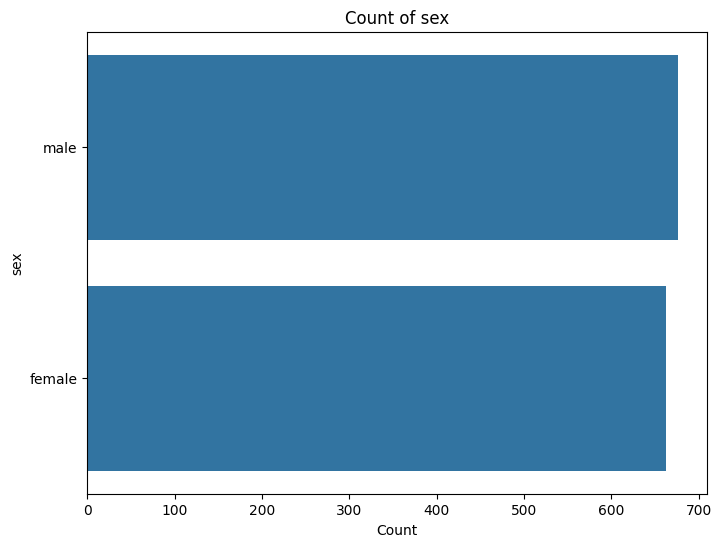

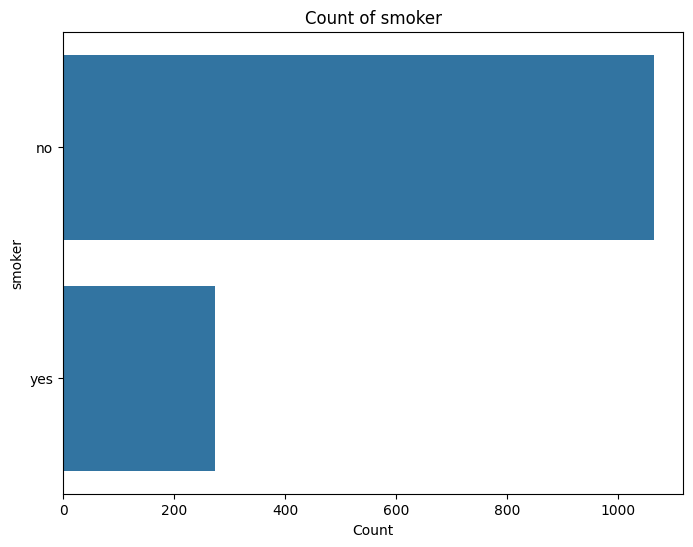

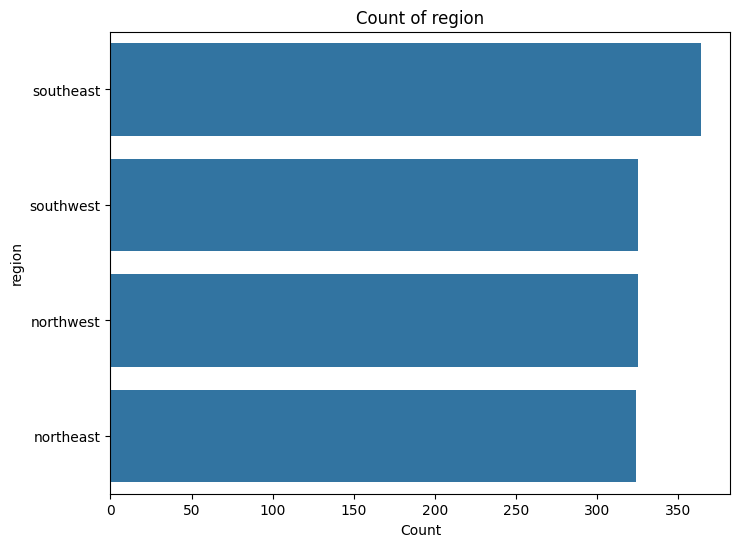

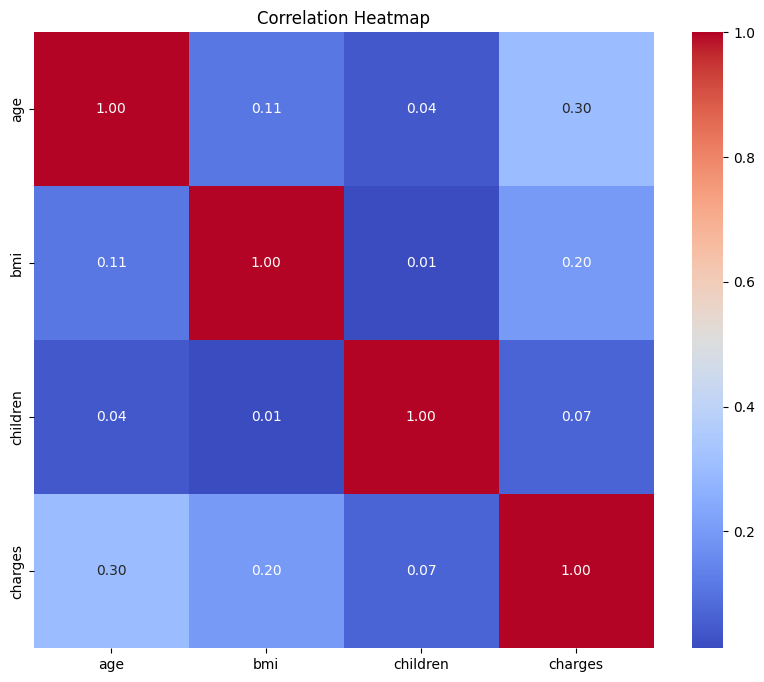

In [3]:
# Numerical features visualisation for EDA
numerical_features = dataset.select_dtypes(include=[np.number]).columns

for col in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=dataset, x=col, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Catergorical Features EDA
categorical_features = dataset.select_dtypes(include=['object']).columns

for col in categorical_features:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=dataset, y=col, order=dataset[col].value_counts().index)
    plt.title(f'Count of {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.show()

# Exclude non-numeric columns for correlation heatmap
numeric_dataset = dataset.select_dtypes(include=[np.number])

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data=numeric_dataset.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


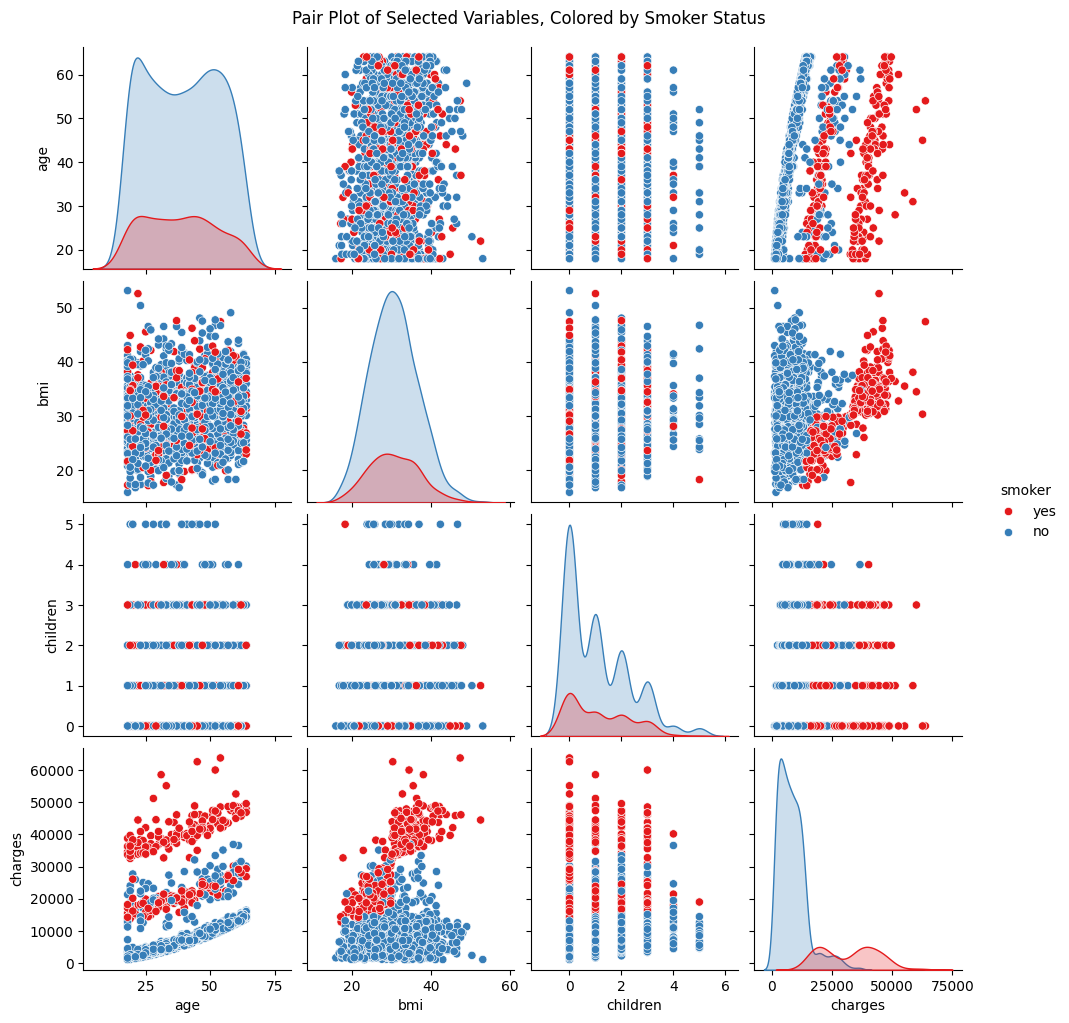

In [4]:
# Creating visualisations for columns
selected_columns = ['age', 'bmi', 'children', 'smoker', 'region', 'charges']
pairplot_data = dataset[selected_columns]

# Using a pair plot to visualize relationships
g = sns.pairplot(pairplot_data, hue='smoker', palette='Set1')
g.fig.suptitle("Pair Plot of Selected Variables, Colored by Smoker Status", y=1.02)  # Adjust 'y' to change the vertical placement
plt.show()


## Adding Noise to the Dataset

We will add laplace and gaussian noise at both randomised and set levels to the dataset. Here we create a function for this.


In [5]:
# Noise functions
def add_laplace_noise(data, epsilon=0.1, sensitivity=1.0):
    delta = sensitivity / epsilon
    return data + np.random.laplace(0, delta, data.shape)

def add_gaussian_noise(data, epsilon=0.1, delta=0.01, sensitivity=1.0):
    sigma = sensitivity * np.sqrt(2 * np.log(1.25 / delta)) / epsilon
    return data + np.random.normal(0, sigma, data.shape)

def add_exponential_noise(data, epsilon):
    scale = 1 / epsilon
    return data + np.random.exponential(scale, data.shape)

def add_ldp_noise(data, epsilon=0.1):
    ldp_data = data.copy()
    scale = 1.0 / epsilon
    noise = np.random.laplace(0, scale, size=ldp_data.shape)
    ldp_data += noise

    return ldp_data


def add_bernoulli_noise(data, epsilon=0.1, base_flip_probability=0.1):
    flip_probability = min(1, base_flip_probability / epsilon)
    flip_mask = np.random.binomial(1, flip_probability, size=data.shape)
    noise = np.random.normal(0, 1, size=data.shape)
    bernoulli_data = data + (flip_mask * noise)
    return bernoulli_data


def add_geometric_noise(data, epsilon=0.1):
    geometric_data = data.copy()
    p = 1 - np.exp(-epsilon)
    noise = np.random.geometric(p, size=geometric_data.shape) - 1
    geometric_data += noise

    return geometric_data



## Randomised Reponse

In this section we will apply randomised response to its own dataset and carry out a seperate evaluation.

In [6]:
def randomised_response(data, p=0.5):

    size = data.shape[0]
    true_response = np.random.rand(size) < p
    unique_values = data.unique()

    if len(unique_values) == 2:
        random_response = np.random.choice(unique_values, size)
    elif len(unique_values) > 2:
        random_response = np.array([np.random.choice([val for val in unique_values if val != x]) for x in data])

    return pd.Series(np.where(true_response, data, random_response), index=data.index)


## Anonymisation techniques

The code defines an anonymise_dataset function that anonymises sensitive attributes like age and BMI by grouping them into predefined categories while also converting the 'children' attribute into a binary representation. This approach aligns with privacy concepts such as k-anonymity, l-diversity, and t-closeness, enhancing the dataset's privacy protection while maintaining its utility for analysis and research.In this context, we have a dataset with quasi-identifiers 'age,' 'sex,' 'bmi,' 'children,' and 'region,' along with the sensitive attribute 'smoker.' To achieve k-anonymity, we can generalise 'age' and 'bmi' into predefined categories (e.g., age groups and BMI categories), ensuring that each group has at least k individuals with the same combination of quasi-identifiers. For 'children,' we apply suppression to hide the exact number of children, making it more challenging to identify individuals. To meet l-diversity and t-closeness requirements, we must ensure that within each group formed by quasi-identifiers, there is a diverse representation of 'smoker' values, preserving privacy and statistical closeness in sensitive attribute distribution.

In [7]:
def anonymise_dataset(df, k=5):
    # Generalise 'age' while trying to ensure each bin has at least 'k' samples
    max_age = df['age'].max()
    age_bins = [0, 18, 25, 35, 45, 55, 65, max_age + 2]
    age_labels = [f'{age_bins[i]}-{age_bins[i+1]-1}' for i in range(len(age_bins)-1)]
    df['age'] = pd.cut(df['age'], bins=age_bins, right=False, labels=age_labels)

    # Update categories
    df['age'] = df['age'].cat.add_categories('Other')

    # Ensure k-anonymity for 'age'
    age_counts = df['age'].value_counts()
    non_k_anon_age_bins = age_counts[age_counts < k].index
    df.loc[df['age'].isin(non_k_anon_age_bins), 'age'] = 'Other'

    # Generalise 'bmi' with balanced bins based on quantiles
    df['bmi'] = pd.qcut(df['bmi'], q=4, duplicates='drop')

    # Generalise 'children' into binary attribute
    df['children'] = df['children'].apply(lambda x: 'Has Children' if x > 0 else 'No Children')

    return df

## Preparing Different Datasets

We will asess gaussian noise and laplace noise at a randomised and fixed level. Therefore these datasets will be made accordingly.



In [8]:
# Noise levels
epsilon_laplace = 0.1
epsilon_gaussian = 0.1
scale_exponential = 1.0
epsilon_geometric = 0.1
epsilon_ldp = 0.1
epsilon_bernoulli = 0.1
flip_probability = 0.1
probability_of_truth = 0.7
delta=1e-5

numeric_cols = ['age', 'bmi', 'children', 'charges']

# Apply Laplace Noise
df_laplace_noise = dataset.copy()
df_laplace_noise[numeric_cols] = add_laplace_noise(df_laplace_noise[numeric_cols], epsilon_laplace)

# Apply Gaussian Noise
df_gaussian_noise = dataset.copy()
df_gaussian_noise[numeric_cols] = add_gaussian_noise(df_gaussian_noise[numeric_cols], epsilon_gaussian)

# Apply Exponential Noise
df_exponential_noise = dataset.copy()
df_exponential_noise[numeric_cols] = add_exponential_noise(df_exponential_noise[numeric_cols], scale_exponential)

# Apply Geometric Noise
df_geometric_noise = dataset.copy()
df_geometric_noise[numeric_cols] = add_geometric_noise(df_geometric_noise[numeric_cols], epsilon_geometric)

# Apply LDP Noise
df_ldp = dataset.copy()
df_ldp[numeric_cols] = add_ldp_noise(df_ldp[numeric_cols], epsilon_ldp)

# Apply Bernoulli Noise
df_bernoulli_noise = dataset.copy()
df_bernoulli_noise[numeric_cols] = add_bernoulli_noise(df_bernoulli_noise[numeric_cols], epsilon_bernoulli, flip_probability)

# Apply Randomised Response
df_rr = dataset.copy()
df_rr['sex'] = randomised_response(df_rr['sex'], probability_of_truth)
df_rr['region'] = randomised_response(df_rr['region'], probability_of_truth)

# Anonymise Dataset
dataset_anonymised = anonymise_dataset(dataset.copy())

# Random Laplace Noise
# epsilon_random_laplace = np.random.uniform(low=0.01, high=0.2, size=dataset[numeric_cols].shape)
# df_random_laplace_noise = dataset.copy()
# df_random_laplace_noise[numeric_cols] = add_laplace_noise(dataset[numeric_cols], epsilon_random_laplace)

# Random Gaussian Noise
# epsilon_random_gaussian = np.random.uniform(low=0.01, high=0.2, size=dataset[numeric_cols].shape)
# df_random_gaussian_noise = dataset.copy()
# df_random_gaussian_noise[numeric_cols] = add_gaussian_noise(dataset[numeric_cols], epsilon_random_gaussian)



In [9]:
#Define preprocessing for the anonymised dataset
def preprocess_anonymised_data(df, categorical_features):
    X = df.drop('smoker', axis=1)
    y = df['smoker'].apply(lambda x: 1 if x == 'yes' else 0)

    # Use Onehotencoder only as all features are catagorical
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(sparse_output=False), categorical_features)
        ])

    X_processed = preprocessor.fit_transform(X)
    return X_processed, y

# Identifying categorical columns for the anonymised dataset
categorical_features_anonymised = dataset_anonymised.select_dtypes(include=['object', 'category']).columns.drop('smoker')

# Preprocess the anonymised dataset
X_anonymised, y_anonymised = preprocess_anonymised_data(dataset_anonymised, categorical_features_anonymised)

#Stratified train-test split for the anonymised dataset
X_train_anonymised, X_test_anonymised, y_train_anonymised, y_test_anonymised = train_test_split(X_anonymised, y_anonymised, test_size=0.2, stratify=y_anonymised, random_state=42)

# Apply SMOTE to the training data of the anonymized dataset
smote = SMOTE(random_state=42)
X_train_smote_anonymised, y_train_smote_anonymised = smote.fit_resample(X_train_anonymised, y_train_anonymised)


In [10]:
# Define the preprocessing function
def preprocess_data(df, numeric_cols, categorical_features):
    X = df.drop('smoker', axis=1)
    y = df['smoker'].apply(lambda x: 1 if x == 'yes' else 0)

    # Defining the transformer for scaling and encoding
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_cols),
            ('cat', OneHotEncoder(sparse_output=False), categorical_features)
        ])

    X_processed = preprocessor.fit_transform(X)
    return X_processed, y

# Identifying numeric and categorical columns
numeric_cols = dataset.select_dtypes(include=[np.number]).columns
categorical_features = dataset.select_dtypes(include=['object']).columns.drop('smoker')

# Preprocess all datasets
X_original, y_original = preprocess_data(dataset, numeric_cols, categorical_features)
X_laplace, y_laplace = preprocess_data(df_laplace_noise, numeric_cols, categorical_features)
X_gaussian, y_gaussian = preprocess_data(df_gaussian_noise, numeric_cols, categorical_features)
X_exponential, y_exponential = preprocess_data(df_exponential_noise, numeric_cols, categorical_features)
X_geometric, y_geometric = preprocess_data(df_geometric_noise, numeric_cols, categorical_features)
X_ldp, y_ldp = preprocess_data(df_ldp, numeric_cols, categorical_features)
X_rr, y_rr = preprocess_data(df_rr, numeric_cols, categorical_features)
X_bernoulli, y_bernoulli = preprocess_data(df_bernoulli_noise, numeric_cols, categorical_features)


# Stratified train-test split for the original dataset
X_train, X_test, y_train, y_test = train_test_split(X_original, y_original, test_size=0.2, stratify=y_original, random_state=42)

# Applying SMOTE to the training data for the original dataset
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


## Machine Learning Models - #1 SVM
Now we will implement each of the machine learning models with the datasets we have created. First Will be the SVM Model.

Best parameters from original dataset: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Classification Report for Original:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       213
           1       0.90      0.96      0.93        55

    accuracy                           0.97       268
   macro avg       0.94      0.97      0.96       268
weighted avg       0.97      0.97      0.97       268


Classification Report for Anonymised Dataset:
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       213
           1       0.31      0.33      0.32        55

    accuracy                           0.71       268
   macro avg       0.56      0.57      0.57       268
weighted avg       0.72      0.71      0.71       268


Classification Report for Laplace Noise:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       213
           1       0.82     

C:\Users\ghobi\AppData\Local\Temp\ipykernel_26932\1373370776.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=[metrics['Accuracy'] for metrics in results.values()], palette="deep")


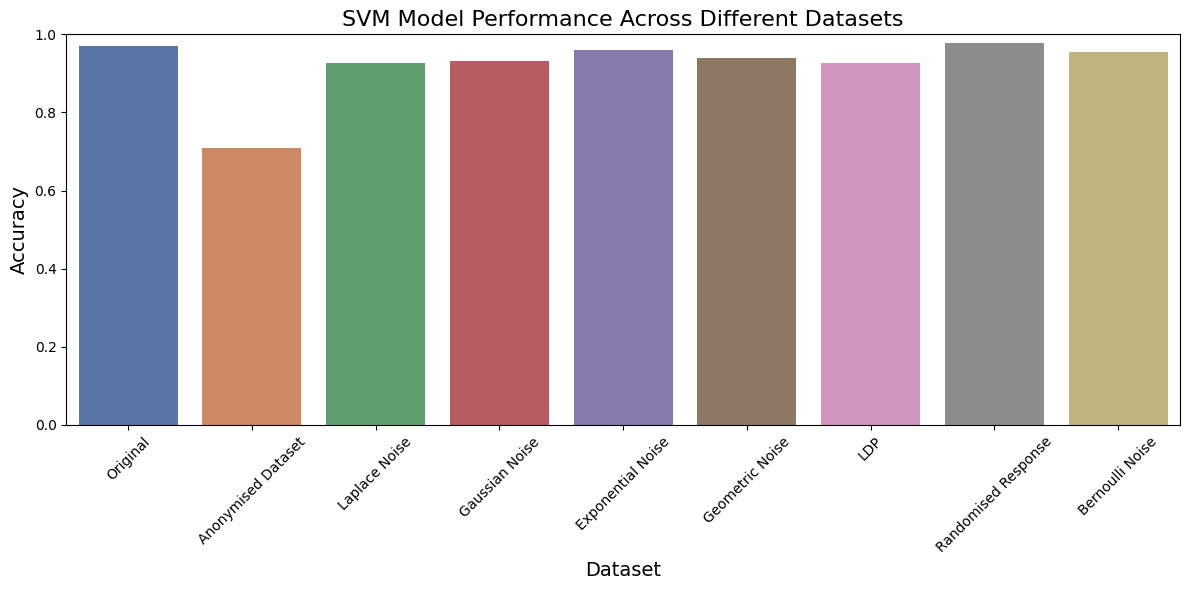

In [45]:
# Grid Search parameters
param_grid = {
    'C': [1, 5, 10, 15, 20],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
}

# Datasets dictionary
datasets = {
    "Original": (X_original, y_original),
    "Anonymised Dataset": (X_anonymised, y_anonymised),
    "Laplace Noise": (X_laplace, y_laplace),
    "Gaussian Noise": (X_gaussian, y_gaussian),
    "Exponential Noise": (X_exponential, y_exponential),
    "Geometric Noise": (X_geometric, y_geometric),
    "LDP": (X_ldp, y_ldp),
    "Randomised Response": (X_rr, y_rr),
    "Bernoulli Noise": (X_bernoulli, y_bernoulli)
}

# Perform Grid Search only on the original dataset
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    datasets['Original'][0], datasets['Original'][1], test_size=0.2, stratify=datasets['Original'][1], random_state=42
)
smote = SMOTE(random_state=42)
X_train_smote_orig, y_train_smote_orig = smote.fit_resample(X_train_orig, y_train_orig)
grid = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_smote_orig, y_train_smote_orig)
best_params_orig = grid.best_params_

# Store and print the best parameters
print(f"Best parameters from original dataset: {best_params_orig}")

# Initialize dictionaries to store results and classification reports
results = {}
class_reports = {}

# Initialize smote outside the loop
smote = SMOTE(random_state=42)

# Use the best parameters found on the original dataset to train and evaluate models on all datasets
for dataset_name, (X, y) in datasets.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Train SVM with best parameters found on original data
    svm_model = SVC(**best_params_orig, probability=True)
    svm_model.fit(X_train_smote, y_train_smote)
    y_pred = svm_model.predict(X_test)

    # Calculate and store metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    results[dataset_name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

    # Store and print the classification report
    class_report = classification_report(y_test, y_pred, zero_division=0)
    class_reports[dataset_name] = class_report
    print(f"Classification Report for {dataset_name}:\n{class_report}\n")
    

# Visualization of model performance
plt.figure(figsize=(12, 6))
sns.barplot(x=list(results.keys()), y=[metrics['Accuracy'] for metrics in results.values()], palette="deep")
plt.title('SVM Model Performance Across Different Datasets', fontsize=16)
plt.xlabel('Dataset', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [35]:
# Create a dictionary with the results
results_dict = {
    "Dataset": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": []
}

# Populate the results_dict with the data
for dataset_name, metrics in results.items():
    results_dict["Dataset"].append(dataset_name)
    results_dict["Accuracy"].append(metrics["Accuracy"])
    results_dict["Precision"].append(metrics["Precision"])
    results_dict["Recall"].append(metrics["Recall"])
    results_dict["F1 Score"].append(metrics["F1 Score"])

# Create a pandas DataFrame
results_df = pd.DataFrame.from_dict(results_dict)

# Display the DataFrame as a nicely formatted table
display(results_df)


Dataset  Accuracy  Precision    Recall  F1 Score
0             Original  0.970149   0.898305  0.963636  0.929825
1   Anonymised Dataset  0.708955   0.305085  0.327273  0.315789
2        Laplace Noise  0.925373   0.818182  0.818182  0.818182
3       Gaussian Noise  0.932836   0.784615  0.927273  0.850000
4    Exponential Noise  0.958955   0.892857  0.909091  0.900901
5      Geometric Noise  0.940299   0.800000  0.945455  0.866667
6                  LDP  0.925373   0.807018  0.836364  0.821429
7  Randomised Response  0.977612   0.929825  0.963636  0.946429
8      Bernoulli Noise  0.955224   0.905660  0.872727  0.888889

In [36]:
# Subsetting Dataset to show noise addition
age_sample = dataset['age'].sample(n=100, random_state=42)
bmi_sample = dataset['bmi'].sample(n=100, random_state=42)

# Apply noise functions to the 'age' and 'bmi' columns
epsilon = 0.1
age_laplace = add_laplace_noise(age_sample, epsilon)
bmi_gaussian = add_gaussian_noise(bmi_sample, epsilon)
age_exponential = add_exponential_noise(age_sample, epsilon)
bmi_ldp = add_ldp_noise(bmi_sample, epsilon)
age_bernoulli = add_bernoulli_noise(age_sample, epsilon)
bmi_geometric = add_geometric_noise(bmi_sample, epsilon)

# Create a dataframe to compare the original and noisy data
noisy_data_comparison = pd.DataFrame({
    'Original Age': age_sample,
    'Age Laplace Noise': age_laplace,
    'Original BMI': bmi_sample,
    'BMI Gaussian Noise': bmi_gaussian,
    'Age Exponential Noise': age_exponential,
    'BMI LDP Noise': bmi_ldp,
    'Age Bernoulli Noise': age_bernoulli,
    'BMI Geometric Noise': bmi_geometric
})

noisy_data_comparison.head()



Original Age  Age Laplace Noise  Original BMI  BMI Gaussian Noise  \
764             45          27.118784        25.175           34.492978   
887             36          40.460095        30.020           19.379065   
890             64          86.593443        26.885          -36.024269   
1293            46          59.020981        25.745            4.902832   
259             19          18.875326        31.920           59.022035   

      Age Exponential Noise  BMI LDP Noise  Age Bernoulli Noise  \
764               76.558550      25.630980            44.184825   
887               81.810860      26.921954            35.219327   
890               69.199473      30.618687            63.826093   
1293              49.537035      22.026445            47.416695   
259               23.165385      39.233731            18.578262   

      BMI Geometric Noise  
764                33.175  
887                34.020  
890                28.885  
1293               42.745  
259                33.920

## Fairness Metrics
Now we will adress the fairness metrics for the SVM Model.

To ensure fairness in my model predictions, I calculated two key fairness metrics: Demographic Parity Difference and Equal Opportunity Difference. These metrics helped me assess how fair the model's predictions were concerning the sensitive attribute 'sex'.

I found that the Demographic Parity Difference values were generally close to zero across all datasets, indicating that the rate of predicting someone as a smoker was nearly equal for different genders. However, the Equal Opportunity Difference values showed some variation, suggesting discrepancies in the true positive rates between genders in certain datasets.



In [ ]:
# Split the data before preprocessing
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42, stratify=dataset['smoker'])

# Sensetive feature testing
sensitive_feature_test = test_set['sex'].apply(lambda x: 1 if x == 'male' else 0)

# After model prediction on the preprocessed test set
# Calculate fairness metrics
dp_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_feature_test)
eo_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_feature_test)

# Print results
print("SVM Demographic Parity Difference:", dp_diff)
print(" SVM Equal Opportunity Difference:", eo_diff)

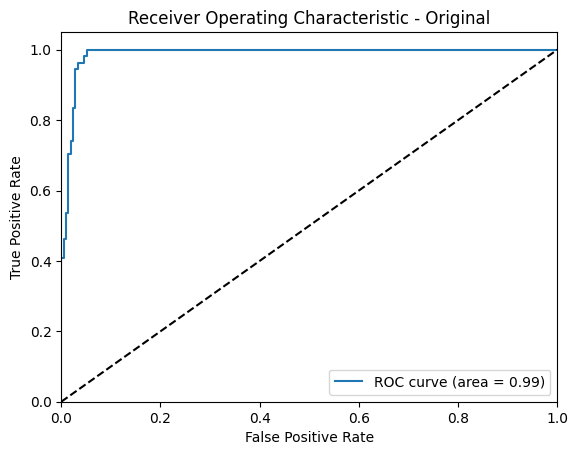

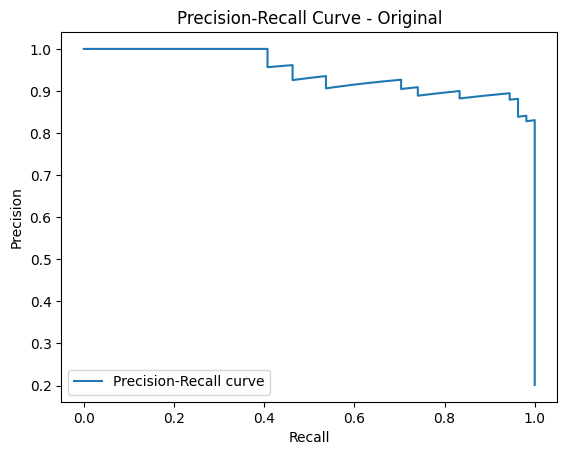

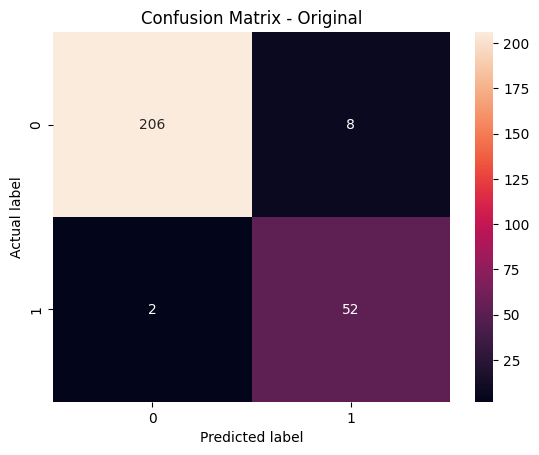

F1-Score for Original: 0.91


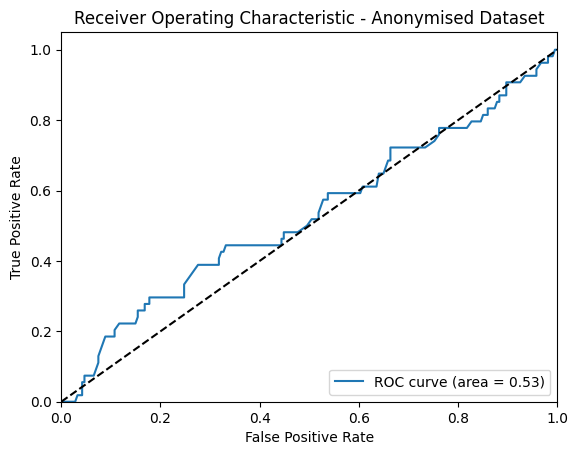

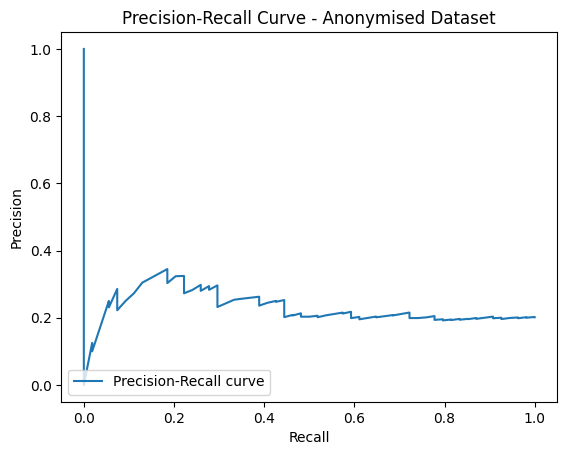

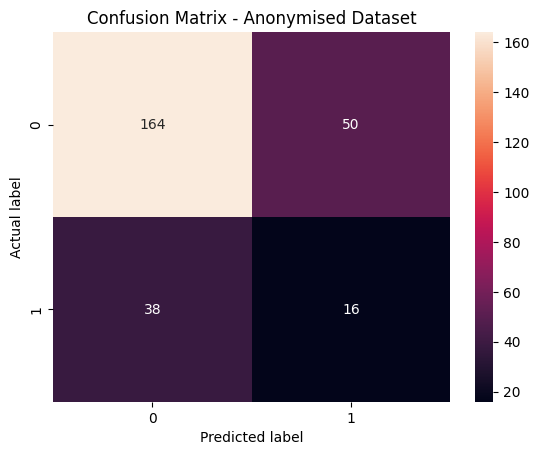

F1-Score for Anonymised Dataset: 0.27


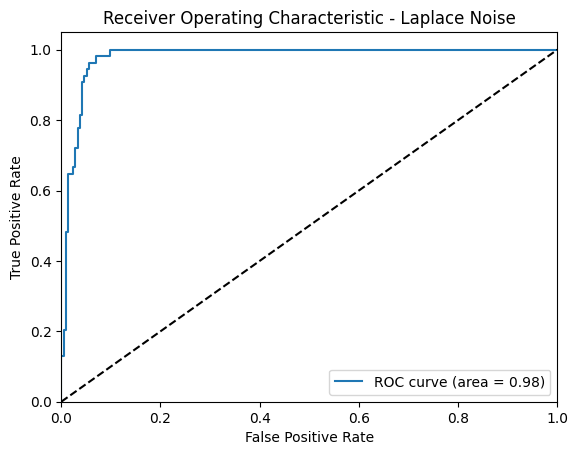

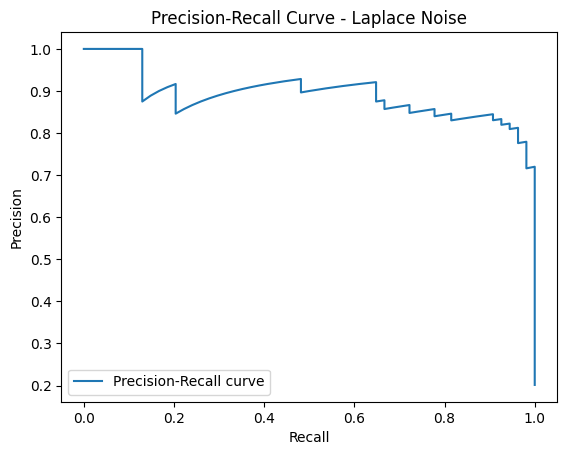

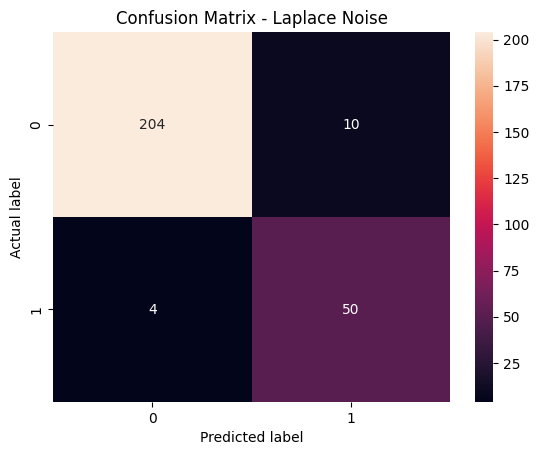

F1-Score for Laplace Noise: 0.88


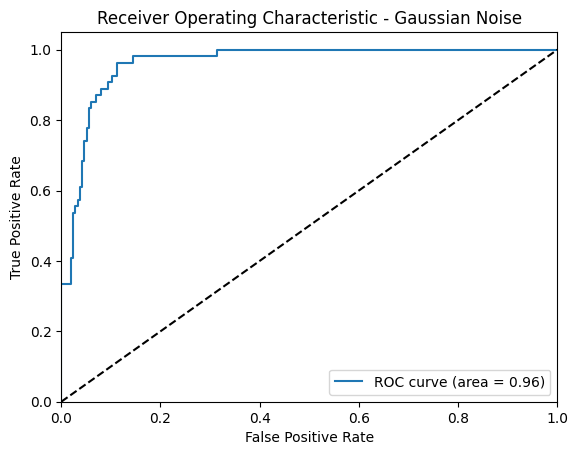

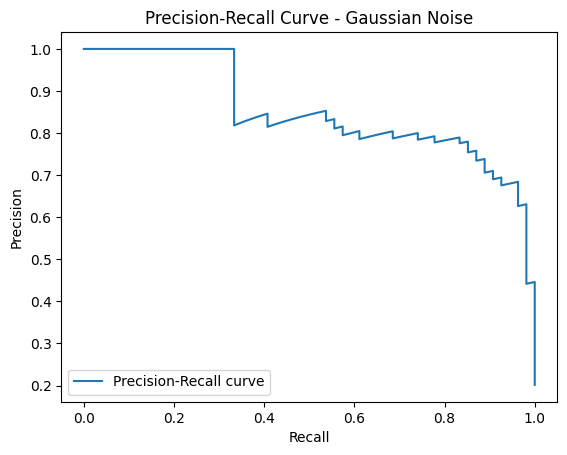

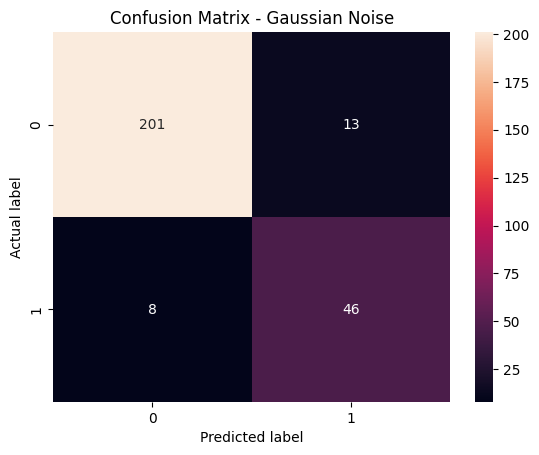

F1-Score for Gaussian Noise: 0.81


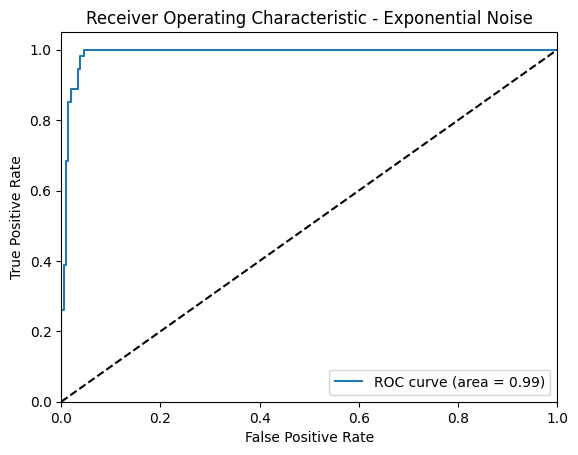

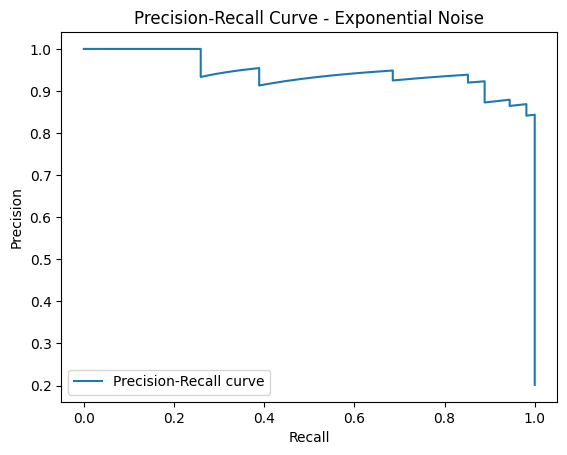

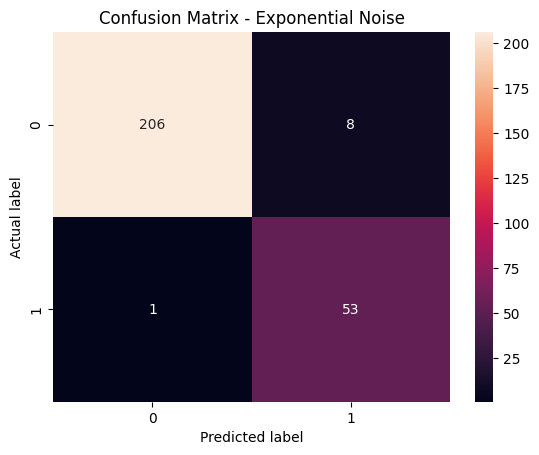

F1-Score for Exponential Noise: 0.92


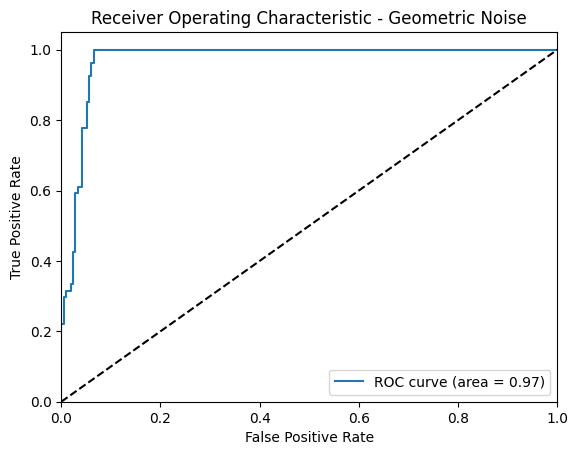

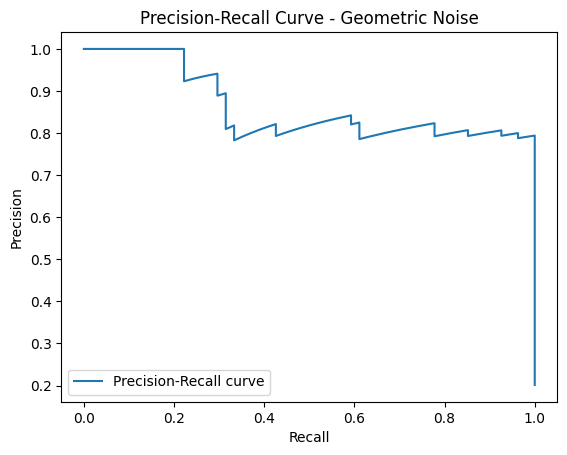

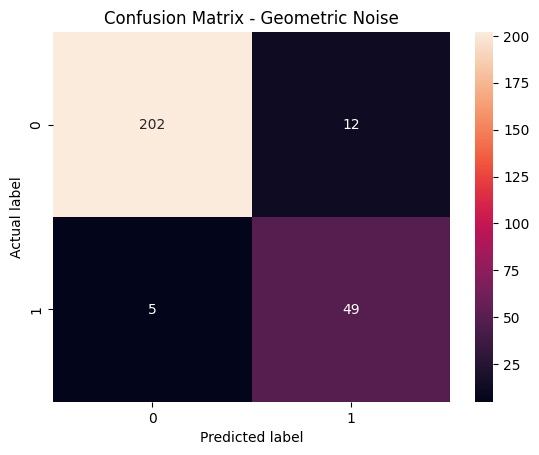

F1-Score for Geometric Noise: 0.85


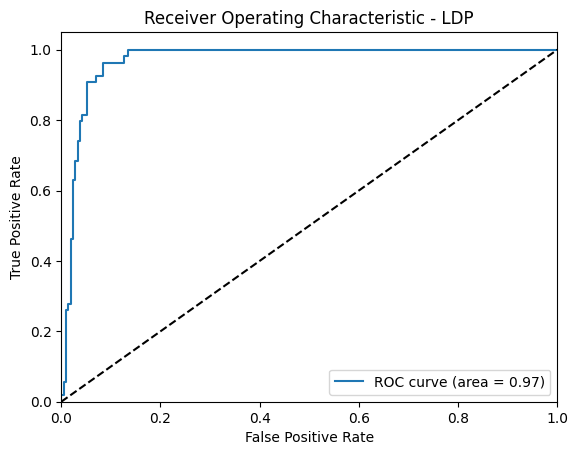

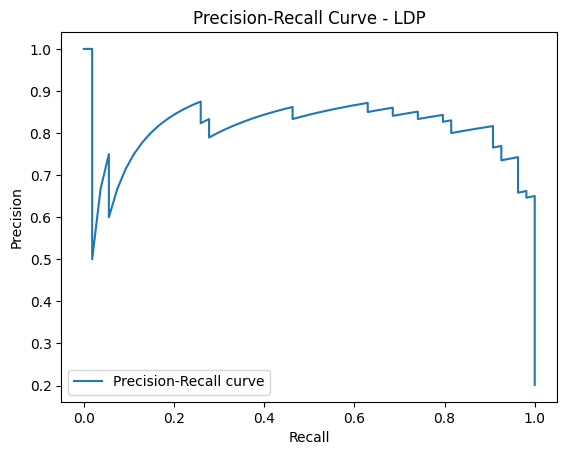

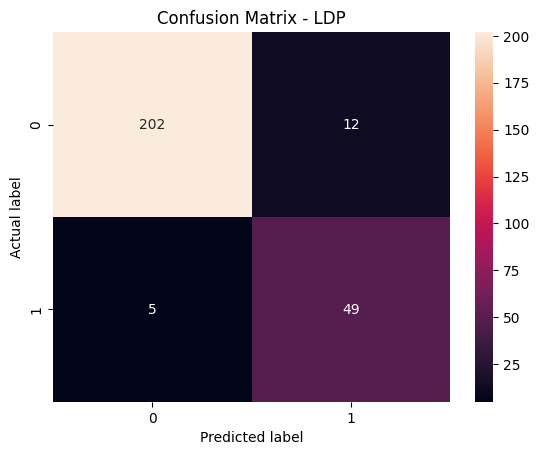

F1-Score for LDP: 0.85


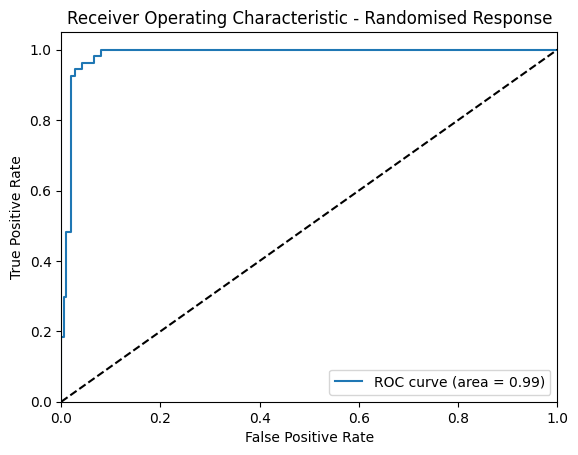

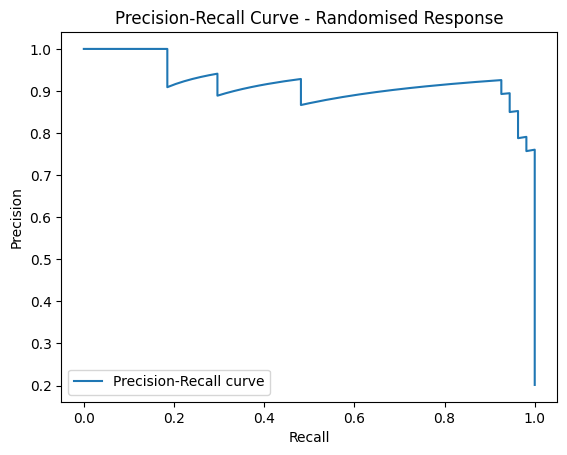

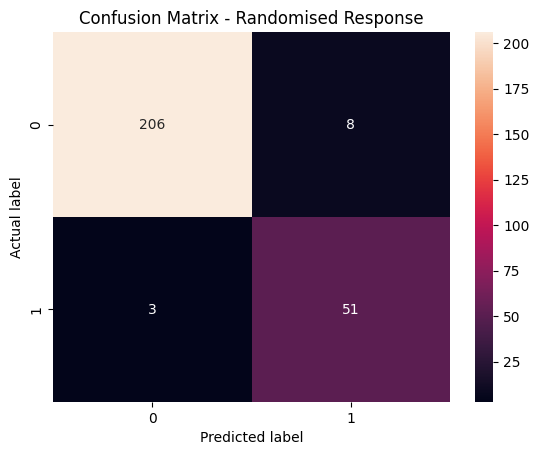

F1-Score for Randomised Response: 0.90


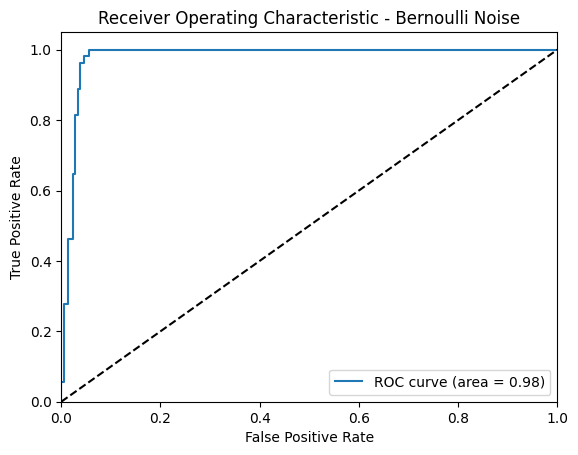

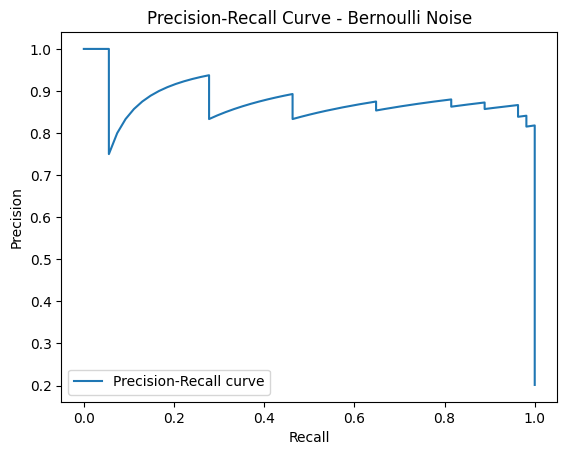

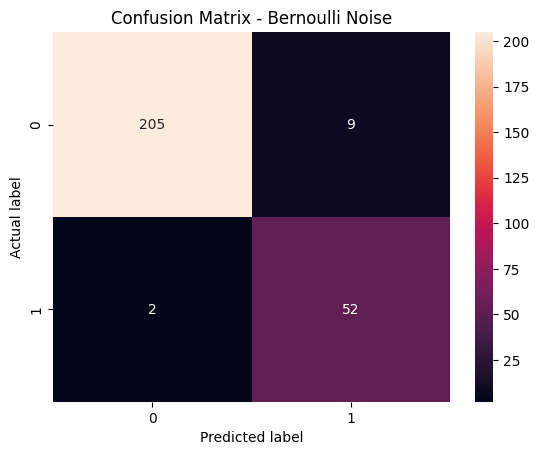

F1-Score for Bernoulli Noise: 0.90


In [37]:
#Additional Visualisations
results = {}

for dataset_name, (X, y) in datasets.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    svm_model = SVC(**grid.best_params_, probability=True)
    svm_model.fit(X_train_smote, y_train_smote)

#Probability of Positive Class
    y_pred = svm_model.predict(X_test)
    y_proba = svm_model.predict_proba(X_test)[:, 1]

    results[dataset_name] = {
        "y_true": y_test,
        "y_pred": y_pred,
        "y_proba": y_proba
    }


for dataset_name, data in results.items():
    y_true, y_pred, y_proba = data["y_true"], data["y_pred"], data["y_proba"]
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    plt.figure()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {dataset_name}')
    plt.legend(loc="lower left")
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    # Additional Metrics
    f1 = f1_score(y_true, y_pred)
    print(f'F1-Score for {dataset_name}: {f1:.2f}')

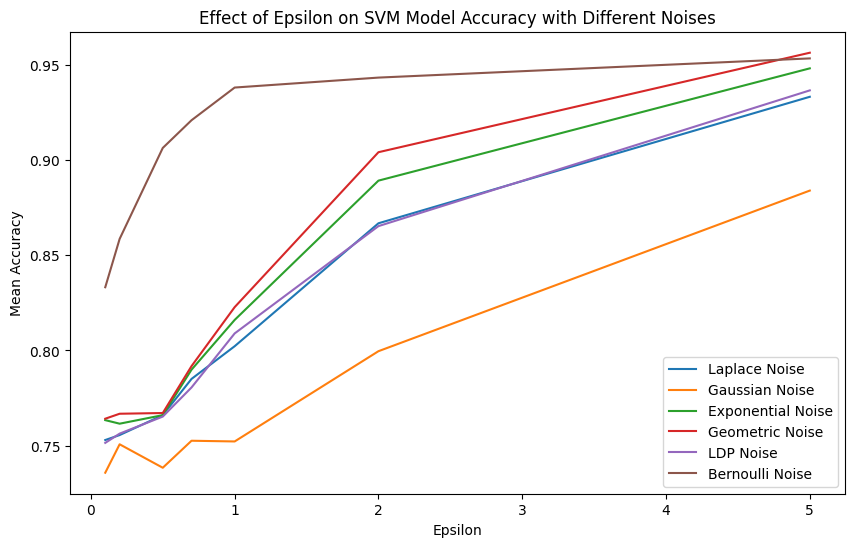

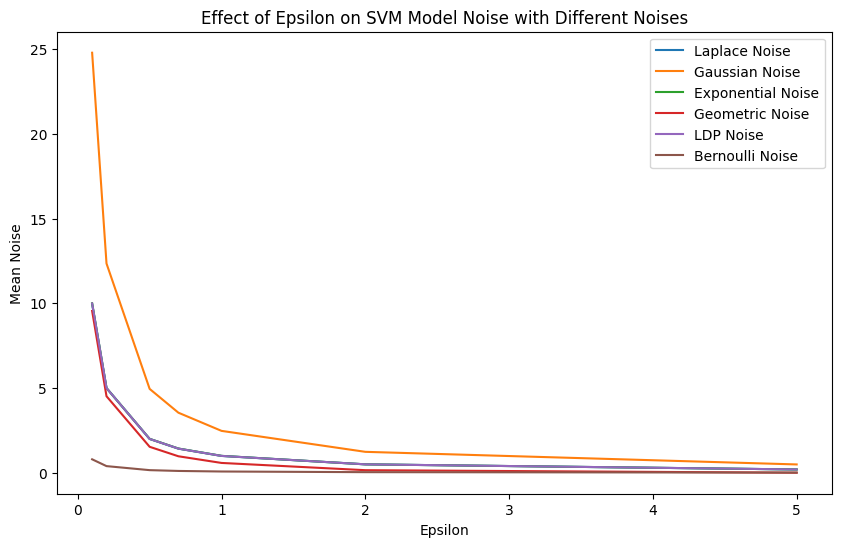

In [61]:
def evaluate_epsilon_effect(epsilon_values, noise_type, best_params, X, y, numeric_indices, runs=10):
    mean_accuracies = []
    mean_noises = []
    for epsilon in epsilon_values:
        accuracies = []
        noises = []
        for _ in range(runs):
            X_noisy = None

            if noise_type == 'laplace':
                X_noisy = add_laplace_noise(X, epsilon=epsilon)
            elif noise_type == 'gaussian':
                X_noisy = add_gaussian_noise(X, epsilon=epsilon)
            elif noise_type == 'exponential':
                X_noisy = add_exponential_noise(X, epsilon=epsilon)
            elif noise_type == 'geometric':
                X_noisy = add_geometric_noise(X, epsilon=epsilon)
            elif noise_type == 'ldp':
                X_noisy = add_ldp_noise(X, epsilon=epsilon)
            elif noise_type == 'bernoulli':
                X_noisy = add_bernoulli_noise(X, epsilon=epsilon)

            if X_noisy is None:
                raise ValueError(f"X_noisy is None for noise_type {noise_type} and epsilon {epsilon}")


            # Calculating accuracies and noises
            svm_model = SVC(**best_params)
            X_train, X_test, y_train, y_test = train_test_split(X_noisy, y, test_size=0.2, random_state=42)
            svm_model.fit(X_train, y_train)
            y_pred = svm_model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            accuracies.append(accuracy)

            noise = np.mean(np.abs(X_noisy - X))
            noises.append(noise)

        mean_accuracy = np.mean(accuracies)
        mean_accuracies.append((epsilon, mean_accuracy))
        mean_noise = np.mean(noises)
        mean_noises.append((epsilon, mean_noise))

    return mean_accuracies, mean_noises

# Column names for the dataset (excluding the target variable 'smoker')
column_names = dataset.columns.drop('smoker')

# Identifying numeric indices
numeric_indices = [i for i, col in enumerate(column_names) if dataset[col].dtype in [np.float64, np.int64]]

# Define a range of epsilon values to test
epsilon_values = [0.1, 0.2, 0.5, 0.7, 1.0, 2.0, 5.0]

# Retrieve the best parameters from your previous grid search
best_params = grid.best_params_

# Column names for the dataset (excluding the target variable 'smoker')
column_names = dataset.columns.drop('smoker')

# Evaluate the effect of epsilon on accuracy and noise for all noise types
laplace_results, laplace_noises = evaluate_epsilon_effect(epsilon_values, 'laplace', best_params, X_original, y_original, numeric_indices)
gaussian_results, gaussian_noises = evaluate_epsilon_effect(epsilon_values, 'gaussian', best_params, X_original, y_original, numeric_indices)
exponential_results, exponential_noises = evaluate_epsilon_effect(epsilon_values, 'exponential', best_params, X_original, y_original, numeric_indices)
geometric_results, geometric_noises = evaluate_epsilon_effect(epsilon_values, 'geometric', best_params, X_original, y_original, numeric_indices)
ldp_results, ldp_noises = evaluate_epsilon_effect(epsilon_values, 'ldp', best_params, X_original, y_original, numeric_indices)
bernoulli_results, bernoulli_noises = evaluate_epsilon_effect(epsilon_values, 'bernoulli', best_params, X_original, y_original, numeric_indices)


# Plotting the results
plt.figure(figsize=(10, 6))
epsilons, laplace_accuracies = zip(*laplace_results)
plt.plot(epsilons, laplace_accuracies, label='Laplace Noise')

epsilons, gaussian_accuracies = zip(*gaussian_results)
plt.plot(epsilons, gaussian_accuracies, label='Gaussian Noise')

epsilons, exponential_accuracies = zip(*exponential_results)
plt.plot(epsilons, exponential_accuracies, label='Exponential Noise')

epsilons, geometric_accuracies = zip(*geometric_results)
plt.plot(epsilons, geometric_accuracies, label='Geometric Noise')

epsilons, ldp_accuracies = zip(*ldp_results)
plt.plot(epsilons, ldp_accuracies, label='LDP Noise')

epsilons, bernoulli_accuracies = zip(*bernoulli_results)
plt.plot(epsilons, bernoulli_accuracies, label='Bernoulli Noise')

plt.xlabel('Epsilon')
plt.ylabel('Mean Accuracy')
plt.title('Effect of Epsilon on SVM Model Accuracy with Different Noises')
plt.legend()
plt.show()

# Plotting the noise
plt.figure(figsize=(10, 6))
epsilons, laplace_noises = zip(*laplace_noises)
plt.plot(epsilons, laplace_noises, label='Laplace Noise')

epsilons, gaussian_noises = zip(*gaussian_noises)
plt.plot(epsilons, gaussian_noises, label='Gaussian Noise')

epsilons, exponential_noises = zip(*exponential_noises)
plt.plot(epsilons, exponential_noises, label='Exponential Noise')

epsilons, geometric_noises = zip(*geometric_noises)
plt.plot(epsilons, geometric_noises, label='Geometric Noise')

epsilons, ldp_noises = zip(*ldp_noises)
plt.plot(epsilons, ldp_noises, label='LDP Noise')

epsilons, bernoulli_noises = zip(*bernoulli_noises)
plt.plot(epsilons, bernoulli_noises, label='Bernoulli Noise')

plt.xlabel('Epsilon')
plt.ylabel('Mean Noise')
plt.title('Effect of Epsilon on SVM Model Noise with Different Noises')
plt.legend()
plt.show()


In [ ]:
def evaluate_and_display_results(epsilon_values, noise_type, best_params, X_original, y_original, column_names):
    results, noises = evaluate_epsilon_effect(epsilon_values, noise_type, best_params, X_original, y_original, column_names)
    print(f"{noise_type.capitalize()} Noise Results:")
    df = pd.DataFrame({'Epsilon': [epsilon for epsilon, _ in results],
                       'Mean Accuracy': [accuracy for _, accuracy in results],
                       'Mean Noise': [next(x[1] for x in noises if x[0] == epsilon) for epsilon, _ in results]})
    display(df)

# Evaluate and display results for each noise type
evaluate_and_display_results(epsilon_values, 'laplace', best_params, X_original, y_original, column_names)
evaluate_and_display_results(epsilon_values, 'gaussian', best_params, X_original, y_original, column_names)
evaluate_and_display_results(epsilon_values, 'exponential', best_params, X_original, y_original, column_names)
evaluate_and_display_results(epsilon_values, 'geometric', best_params, X_original, y_original, column_names)
evaluate_and_display_results(epsilon_values, 'ldp', best_params, X_original, y_original, column_names)
evaluate_and_display_results(epsilon_values, 'bernoulli', best_params, X_original, y_original, column_names)

In [ ]:
# Define the results dictionary
results = {
    'laplace': {'epsilons': epsilon_values, 'noises': laplace_noises},
    'gaussian': {'epsilons': epsilon_values, 'noises': gaussian_noises},
    'exponential': {'epsilons': epsilon_values, 'noises': exponential_noises},
    'geometric': {'epsilons': epsilon_values, 'noises': geometric_noises},
    'ldp': {'epsilons': epsilon_values, 'noises': ldp_noises},
    'bernoulli': {'epsilons': epsilon_values, 'noises': bernoulli_noises}
}

# Function to calculate statistical metrics
def calculate_metrics(data):
    metrics_data = []
    for noise_type, values in data.items():
        noises = np.array([noise[1] for noise in values['noises']])

        # Calculating metrics
        mean_abs_error = np.mean(np.abs(noises))
        accuracy_std_dev = np.std(noises)
        noise_std_dev = np.std([noise for noise in values['noises']])  # Calculate standard deviation of the noise

        metrics_data.append([noise_type, mean_abs_error, accuracy_std_dev, noise_std_dev])

    # Update DataFrame column names to include Noise Standard Deviation
    metrics_df = pd.DataFrame(metrics_data, columns=['Noise Type', 'Mean Absolute Error', 'Standard Deviation for Accuracy', 'Standard Deviation for Noise'])
    
    # Display the DataFrame as a nicely formatted table
    display(metrics_df)

# Calculate and print metrics
calculate_metrics(results)


## Machine Learning Models - #2 Neural Network
Now, we have finished the implementation of the SVM. We will move onto the Neural Network (NN) algorithm.

12/23/2023 09:56:12:WARNING:From C:\Users\ghobi\anaconda3\Lib\site-packages\keras\src\backend.py:873: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



12/23/2023 09:56:12:WARNING:From C:\Users\ghobi\anaconda3\Lib\site-packages\keras\src\optimizers\__init__.py:309: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



12/23/2023 09:56:13:WARNING:From C:\Users\ghobi\anaconda3\Lib\site-packages\keras\src\utils\tf_utils.py:492: The name tf.ragged.RaggedTensorValue is deprecated. Please use tf.compat.v1.ragged.RaggedTensorValue instead.



12/23/2023 09:56:13:WARNING:From C:\Users\ghobi\anaconda3\Lib\site-packages\keras\src\engine\base_layer_utils.py:384: The name tf.executing_eagerly_outside_functions is deprecated. Please use tf.compat.v1.executing_eagerly_outside_functions instead.



9/9 [==============================] - 0s 758us/step
Mean Average Metrics for Each Dataset:


Accuracy  Precision    Recall  F1 Score
Original             0.961879   0.843430  1.000000  0.914971
Anonymised Dataset   0.565789   0.227965  0.485185  0.307902
Laplace Noise        0.929725   0.762282  0.959798  0.848801
Gaussian Noise       0.928241   0.752640  0.970909  0.847523
Exponential Noise    0.958131   0.833403  0.996364  0.907308
Geometric Noise      0.936450   0.777367  0.970774  0.862772
LDP                  0.927489   0.756765  0.956296  0.844001
Randomised Response  0.962628   0.846024  1.000000  0.916509

C:\Users\ghobi\AppData\Local\Temp\ipykernel_26932\902037045.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=average_results_df, x=average_results_df.index, y='Accuracy', palette="deep")


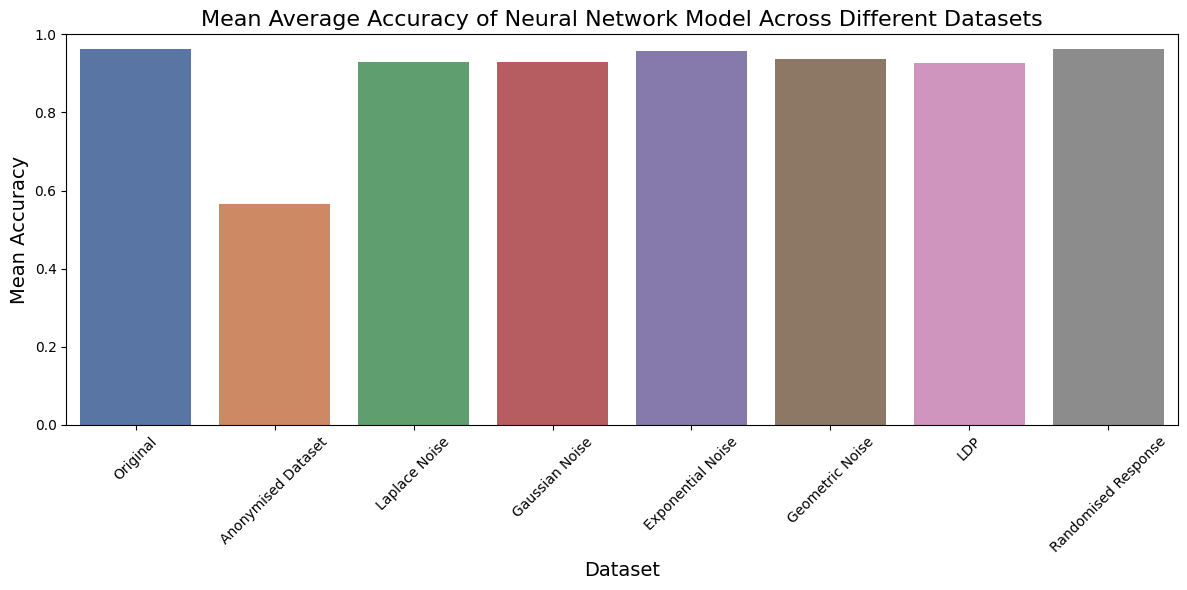

In [11]:
# Dictionary to hold the datasets
datasets = {
    "Original": (X_original, y_original),
    "Anonymised Dataset": (X_anonymised, y_anonymised),
    "Laplace Noise": (X_laplace, y_laplace),
    "Gaussian Noise": (X_gaussian, y_gaussian),
    "Exponential Noise": (X_exponential, y_exponential),
    "Geometric Noise": (X_geometric, y_geometric),
    "LDP": (X_ldp, y_ldp),
    "Randomised Response": (X_rr, y_rr)
}

# Dictionary to store the results and classification reports
results = {}
class_reports = {}

# Function to create a neural network model
def create_model(input_dim, regularization=0.01):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu', kernel_regularizer=l2(regularization)))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(regularization)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Initialize an empty DataFrame to store average results
average_results_df = pd.DataFrame()

# Train and evaluate the neural network model on each dataset with cross-validation
for dataset_name, (X, y) in datasets.items():
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    metrics_dict = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Apply SMOTE to the training set
        smote = SMOTE(random_state=42)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

        # Create and train the neural network model
        model = create_model(input_dim=X_train_smote.shape[1])
        model.fit(X_train_smote, y_train_smote, epochs=100, batch_size=32, verbose=0,
                  validation_data=(X_test, y_test), callbacks=[early_stopping])

        # Evaluate the model
        y_pred = (model.predict(X_test) > 0.5).astype("int32").flatten()
        metrics_dict['Accuracy'].append(accuracy_score(y_test, y_pred))
        metrics_dict['Precision'].append(precision_score(y_test, y_pred, zero_division=0))
        metrics_dict['Recall'].append(recall_score(y_test, y_pred, zero_division=0))
        metrics_dict['F1 Score'].append(f1_score(y_test, y_pred, zero_division=0))

    # Calculating mean of each metric and creating a DataFrame for current dataset
    dataset_metrics_df = pd.DataFrame({metric: [np.mean(values)] for metric, values in metrics_dict.items()}, index=[dataset_name])

    # Concatenating with the main DataFrame
    average_results_df = pd.concat([average_results_df, dataset_metrics_df])

# Displaying the results in a DataFrame
print("Mean Average Metrics for Each Dataset:")
display(average_results_df)

# Visualization of mean average accuracy
plt.figure(figsize=(12, 6))
sns.barplot(data=average_results_df, x=average_results_df.index, y='Accuracy', palette="deep")
plt.title('Mean Average Accuracy of Neural Network Model Across Different Datasets', fontsize=16)
plt.xlabel('Dataset', fontsize=14)
plt.ylabel('Mean Accuracy', fontsize=14)
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

9/9 [==============================] - 0s 751us/step


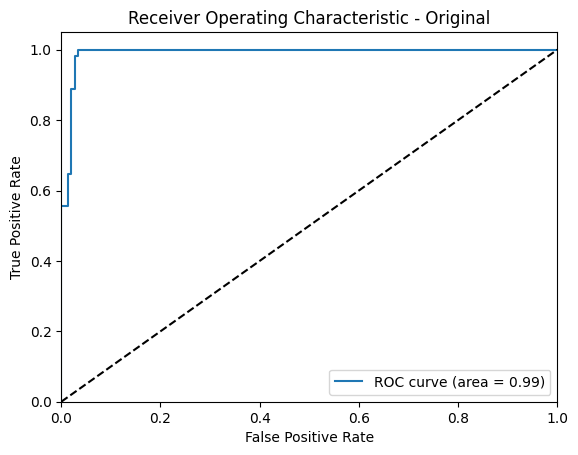

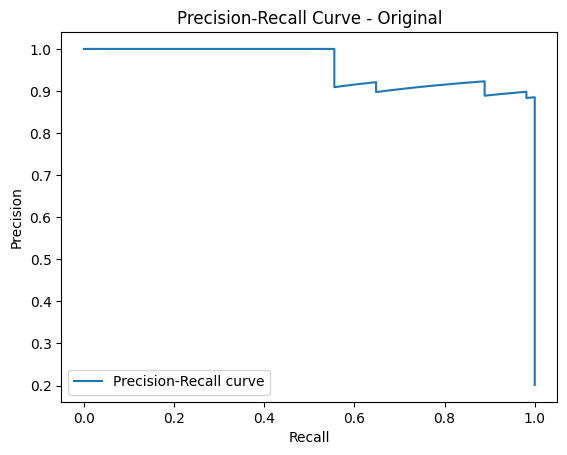

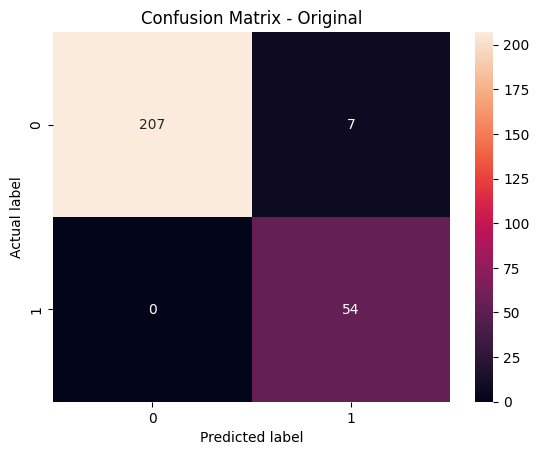

F1-Score for Original: 0.94


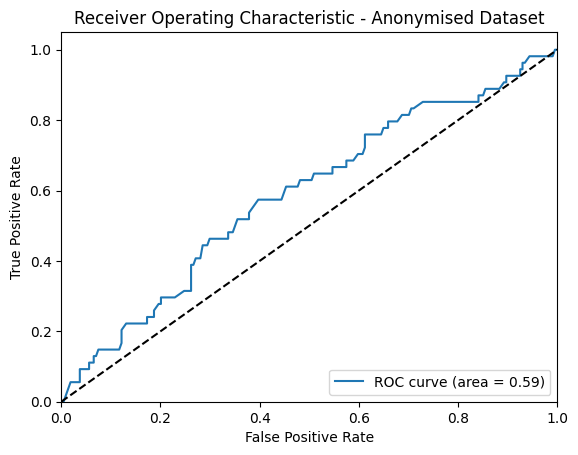

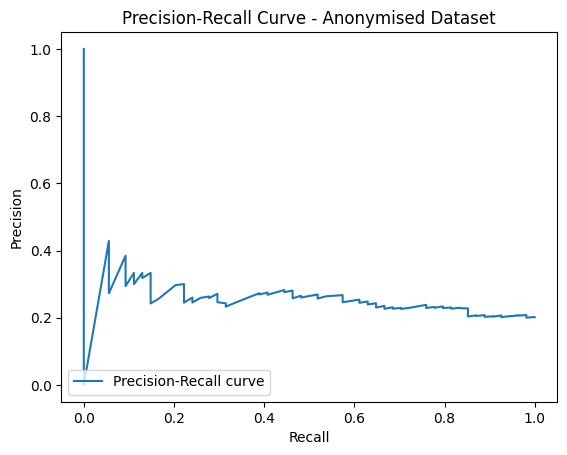

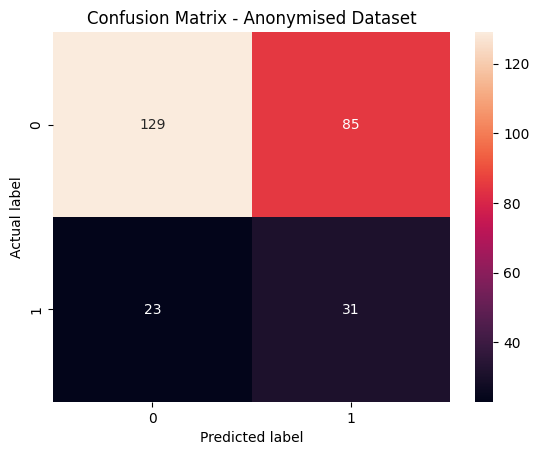

F1-Score for Anonymised Dataset: 0.36


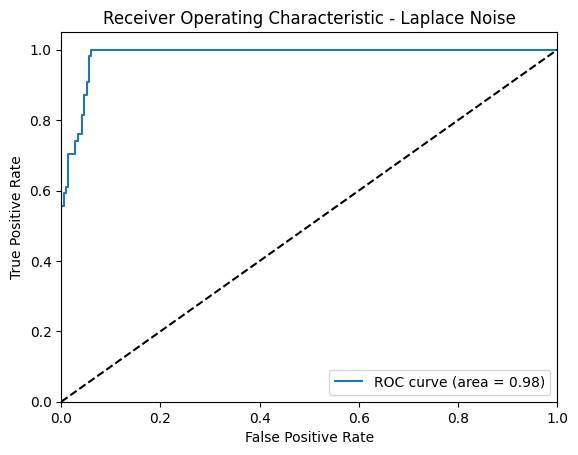

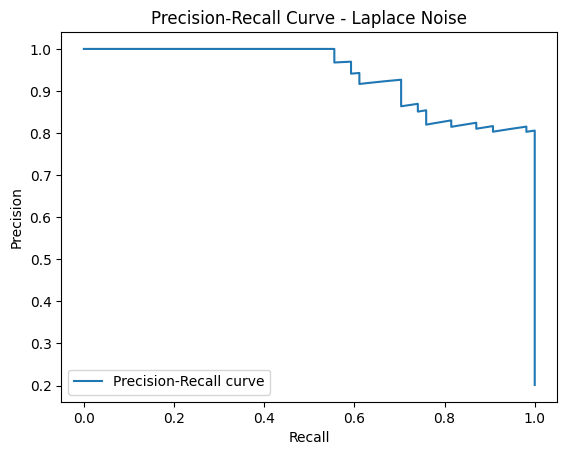

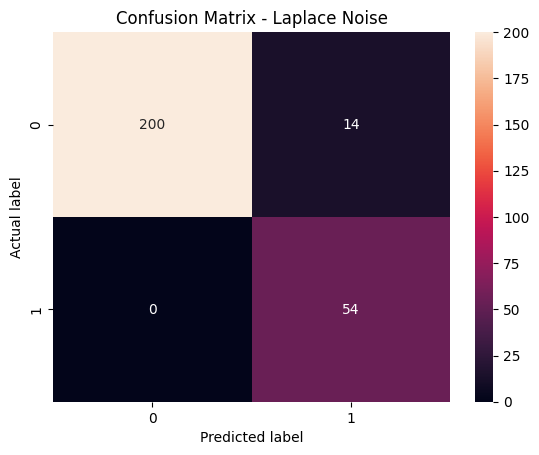

F1-Score for Laplace Noise: 0.89


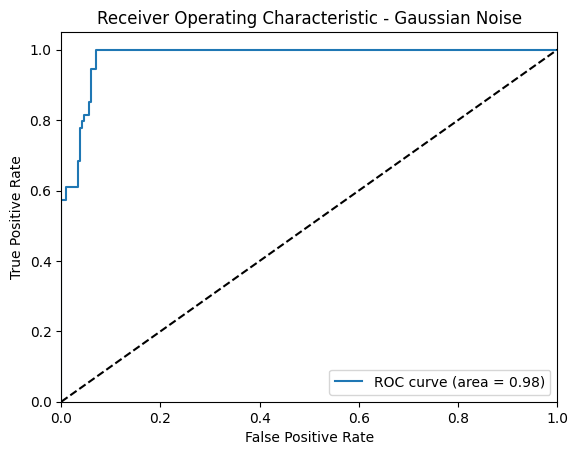

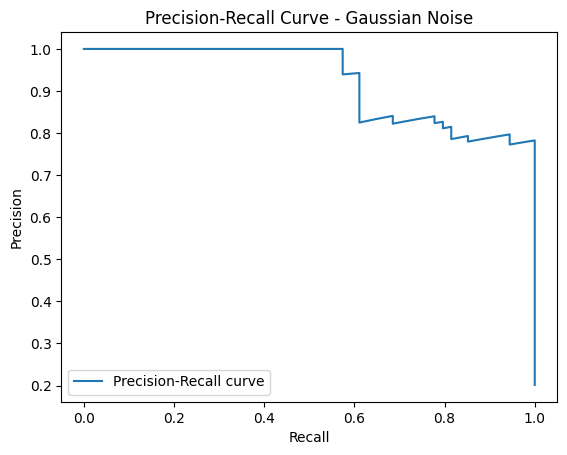

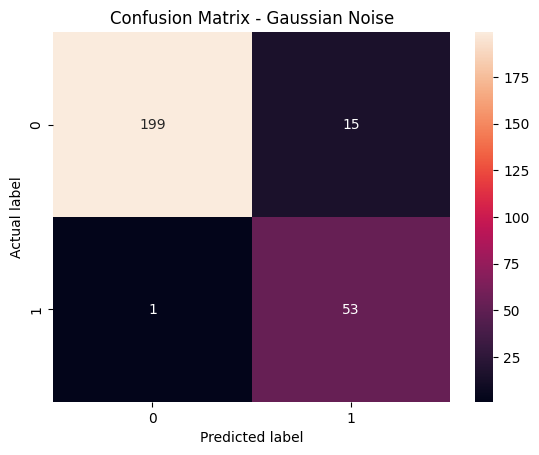

F1-Score for Gaussian Noise: 0.87


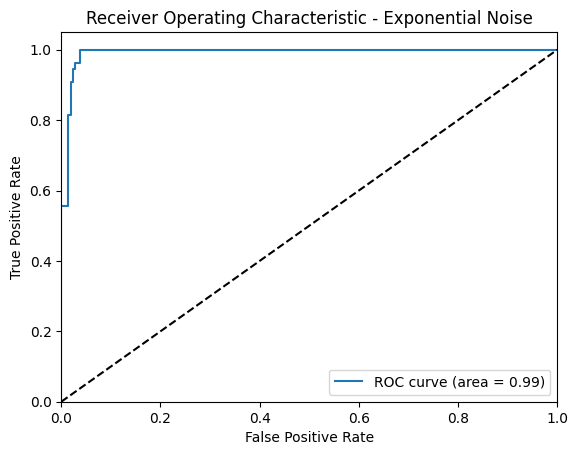

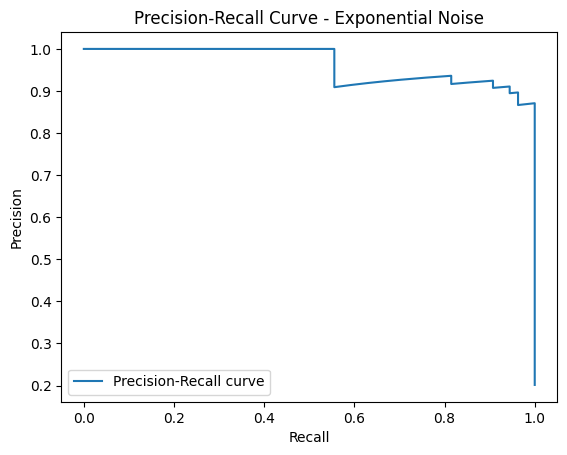

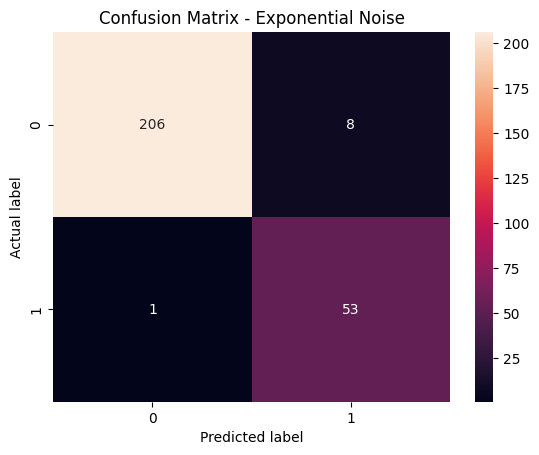

F1-Score for Exponential Noise: 0.92


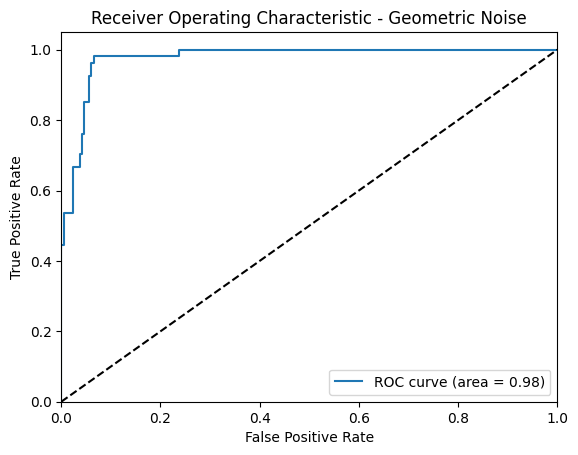

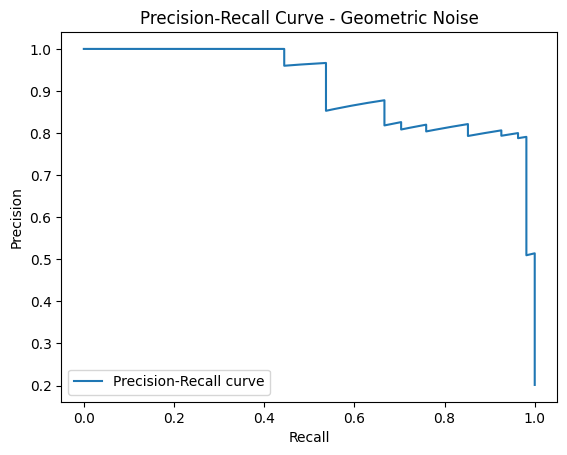

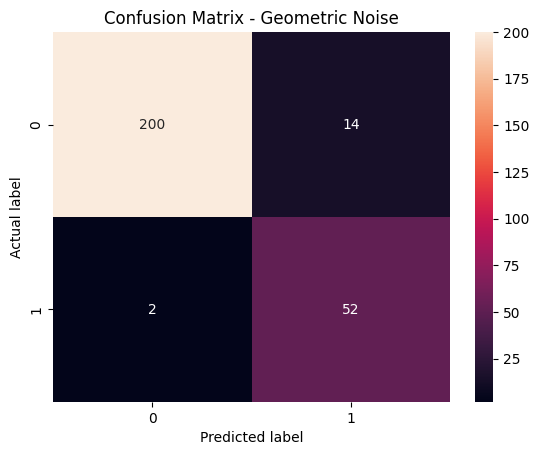

F1-Score for Geometric Noise: 0.87


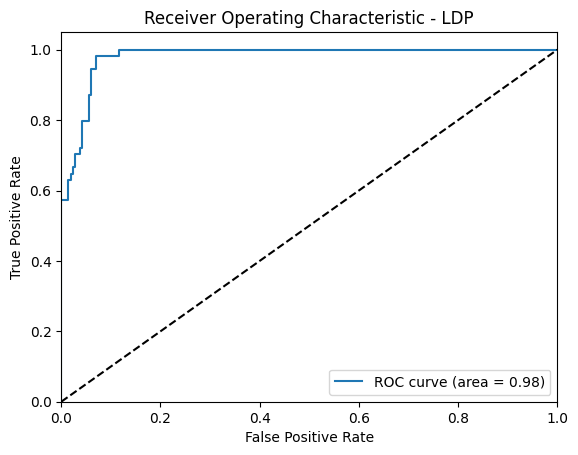

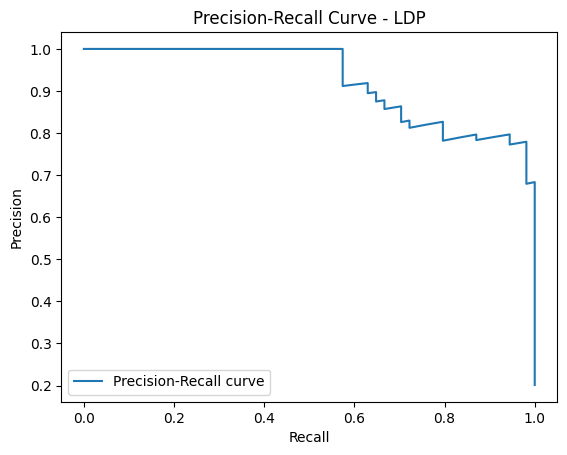

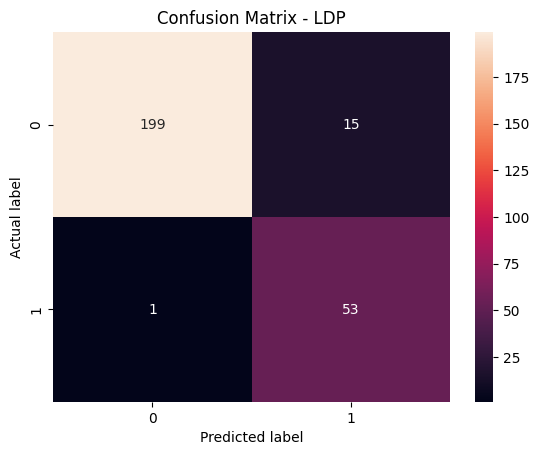

F1-Score for LDP: 0.87


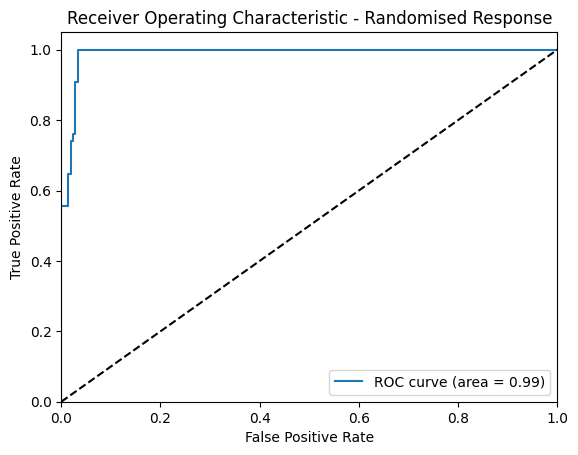

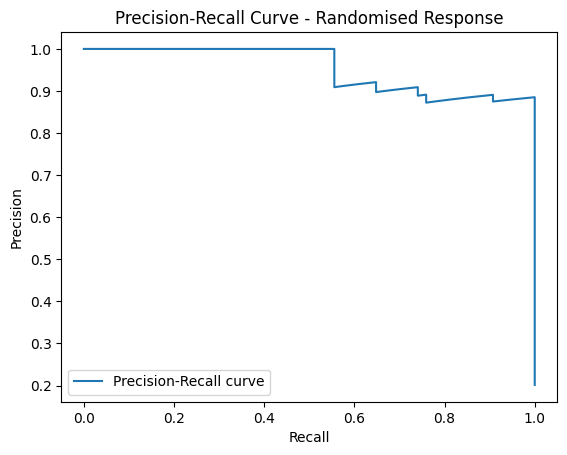

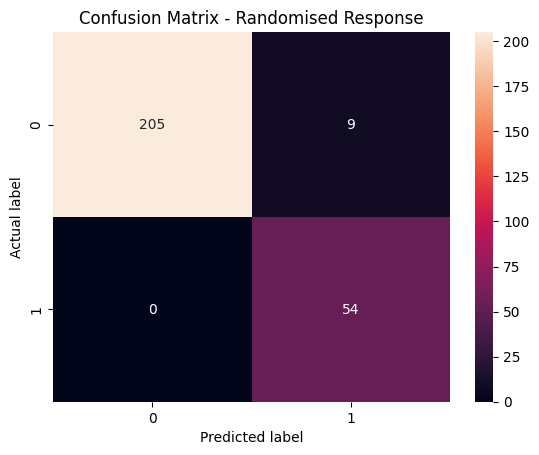

F1-Score for Randomised Response: 0.92


In [17]:
# Additional Visualizations
results = {}

for dataset_name, (X, y) in datasets.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Create and train the neural network model
    model = create_model(input_dim=X_train_smote.shape[1])
    model.fit(X_train_smote, y_train_smote, epochs=100, batch_size=32, verbose=0)

    # Probability of Positive Class
    y_proba = model.predict(X_test)

    # Convert predicted probabilities to binary classes (0 or 1) using a threshold of 0.5
    y_pred = (y_proba > 0.5).astype("int32")

    results[dataset_name] = {
        "y_true": y_test,
        "y_pred": y_pred,
        "y_proba": y_proba
    }

for dataset_name, data in results.items():
    y_true, y_pred, y_proba = data["y_true"], data["y_pred"], data["y_proba"]
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    plt.figure()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {dataset_name}')
    plt.legend(loc="lower left")
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    # Additional Metrics
    f1 = f1_score(y_true, y_pred)
    print(f'F1-Score for {dataset_name}: {f1:.2f}')


9/9 [==============================] - 0s 626us/step


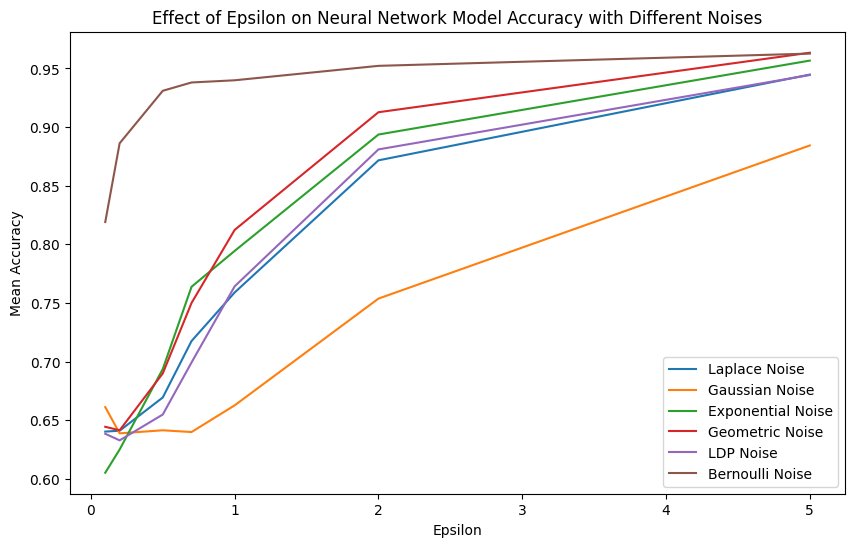

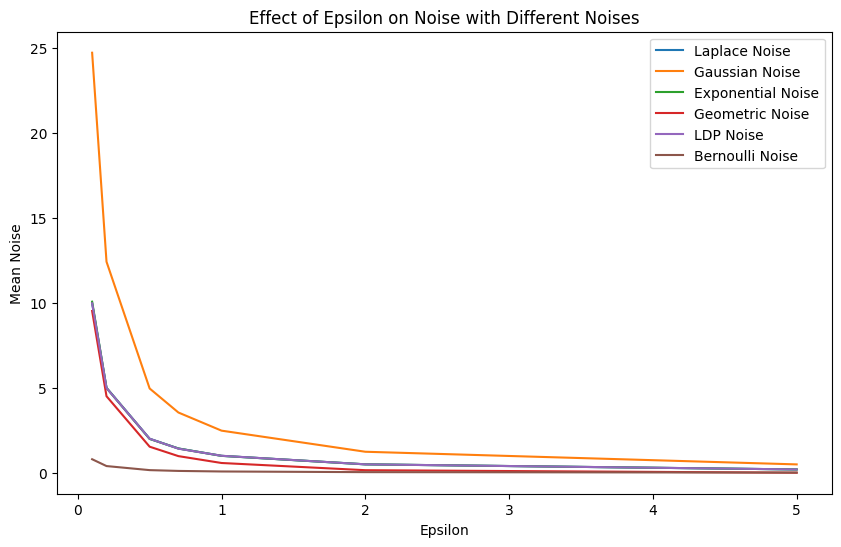

In [18]:
# Function to create a neural network model
def create_neural_network(input_dim, regularization=0.01):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu', kernel_regularizer=l2(regularization)))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(regularization)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def evaluate_epsilon_effect(epsilon_values, noise_type, X, y, numeric_indices, runs=10):
    mean_accuracies = []
    mean_noises = []
    for epsilon in epsilon_values:
        accuracies = []
        noises = []
        for _ in range(runs):
            X_noisy = None

            if noise_type == 'laplace':
                X_noisy = add_laplace_noise(X, epsilon=epsilon)
            elif noise_type == 'gaussian':
                X_noisy = add_gaussian_noise(X, epsilon=epsilon)
            elif noise_type == 'exponential':
                X_noisy = add_exponential_noise(X, epsilon=epsilon)
            elif noise_type == 'geometric':
                X_noisy = add_geometric_noise(X, epsilon=epsilon)
            elif noise_type == 'ldp':
                X_noisy = add_ldp_noise(X, epsilon=epsilon)
            elif noise_type == 'bernoulli':
                X_noisy = add_bernoulli_noise(X, epsilon=epsilon)

            if X_noisy is None:
                raise ValueError(f"X_noisy is None for noise_type {noise_type} and epsilon {epsilon}")

            # Splitting the dataset into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X_noisy, y, test_size=0.2, random_state=42)

            # Apply SMOTE to the training set
            smote = SMOTE(random_state=42)
            X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

            # Create and train the neural network model
            model = create_neural_network(input_dim=X_train_smote.shape[1])
            model.fit(X_train_smote, y_train_smote, epochs=100, batch_size=32, verbose=0,
                      validation_data=(X_test, y_test), callbacks=[early_stopping])

            # Evaluate the model
            y_pred = (model.predict(X_test) > 0.5).astype("int32").flatten()
            accuracy = accuracy_score(y_test, y_pred)
            accuracies.append(accuracy)

            noise = np.mean(np.abs(X_noisy - X))
            noises.append(noise)

        mean_accuracy = np.mean(accuracies)
        mean_accuracies.append((epsilon, mean_accuracy))
        mean_noise = np.mean(noises)
        mean_noises.append((epsilon, mean_noise))

    return mean_accuracies, mean_noises

# Column names for the dataset (excluding the target variable 'smoker')
column_names = dataset.columns.drop('smoker')

# Identifying numeric indices
numeric_indices = [i for i, col in enumerate(column_names) if dataset[col].dtype in [np.float64, np.int64]]

# Define a range of epsilon values to test
epsilon_values = [0.1, 0.2, 0.5, 0.7, 1.0, 2.0, 5.0]

# Evaluate the effect of epsilon on accuracy and noise for all noise types
laplace_results, laplace_noises = evaluate_epsilon_effect(epsilon_values, 'laplace', X_original, y_original, numeric_indices)
gaussian_results, gaussian_noises = evaluate_epsilon_effect(epsilon_values, 'gaussian', X_original, y_original, numeric_indices)
exponential_results, exponential_noises = evaluate_epsilon_effect(epsilon_values, 'exponential', X_original, y_original, numeric_indices)
geometric_results, geometric_noises = evaluate_epsilon_effect(epsilon_values, 'geometric', X_original, y_original, numeric_indices)
ldp_results, ldp_noises = evaluate_epsilon_effect(epsilon_values, 'ldp', X_original, y_original, numeric_indices)
bernoulli_results, bernoulli_noises = evaluate_epsilon_effect(epsilon_values, 'bernoulli', X_original, y_original, numeric_indices)

# Plotting the results
plt.figure(figsize=(10, 6))
epsilons, laplace_accuracies = zip(*laplace_results)
plt.plot(epsilons, laplace_accuracies, label='Laplace Noise')

epsilons, gaussian_accuracies = zip(*gaussian_results)
plt.plot(epsilons, gaussian_accuracies, label='Gaussian Noise')

epsilons, exponential_accuracies = zip(*exponential_results)
plt.plot(epsilons, exponential_accuracies, label='Exponential Noise')

epsilons, geometric_accuracies = zip(*geometric_results)
plt.plot(epsilons, geometric_accuracies, label='Geometric Noise')

epsilons, ldp_accuracies = zip(*ldp_results)
plt.plot(epsilons, ldp_accuracies, label='LDP Noise')

epsilons, bernoulli_accuracies = zip(*bernoulli_results)
plt.plot(epsilons, bernoulli_accuracies, label='Bernoulli Noise')

plt.xlabel('Epsilon')
plt.ylabel('Mean Accuracy')
plt.title('Effect of Epsilon on Neural Network Model Accuracy with Different Noises')
plt.legend()
plt.show()

# Plotting the noise
plt.figure(figsize=(10, 6))
epsilons, laplace_noises = zip(*laplace_noises)
plt.plot(epsilons, laplace_noises, label='Laplace Noise')

epsilons, gaussian_noises = zip(*gaussian_noises)
plt.plot(epsilons, gaussian_noises, label='Gaussian Noise')

epsilons, exponential_noises = zip(*exponential_noises)
plt.plot(epsilons, exponential_noises, label='Exponential Noise')

epsilons, geometric_noises = zip(*geometric_noises)
plt.plot(epsilons, geometric_noises, label='Geometric Noise')

epsilons, ldp_noises = zip(*ldp_noises)
plt.plot(epsilons, ldp_noises, label='LDP Noise')

epsilons, bernoulli_noises = zip(*bernoulli_noises)
plt.plot(epsilons, bernoulli_noises, label='Bernoulli Noise')

plt.xlabel('Epsilon')
plt.ylabel('Mean Noise')
plt.title('Effect of Epsilon on Noise with Different Noises')
plt.legend()
plt.show()


In [20]:
# Function to return results in a DataFrame
def results_to_dataframe(results, noises, noise_type):
    data = []
    for i in range(len(results)):
        epsilon = results[i][0] if isinstance(results[i], tuple) else results[i]
        accuracy = results[i][1] if isinstance(results[i], tuple) else None
        noise = noises[i][1] if isinstance(noises[i], tuple) else noises[i]

        accuracy_str = f"{accuracy:.2f}" if accuracy is not None else "N/A"
        data.append([epsilon, accuracy_str, f"{noise:.2f}"])
    
    columns = ["Epsilon", "Mean Accuracy", "Mean Noise"]
    df = pd.DataFrame(data, columns=columns)
    return df

# Extract results for each noise type and convert them to DataFrames
laplace_df = results_to_dataframe(laplace_results, laplace_noises, 'Laplace')
gaussian_df = results_to_dataframe(gaussian_results, gaussian_noises, 'Gaussian')
exponential_df = results_to_dataframe(exponential_results, exponential_noises, 'Exponential')
geometric_df = results_to_dataframe(geometric_results, geometric_noises, 'Geometric')
ldp_df = results_to_dataframe(ldp_results, ldp_noises, 'LDP')
bernoulli_df = results_to_dataframe(bernoulli_results, bernoulli_noises, 'Bernoulli')

# Display DataFrames
print("Results Table for Different Noises:")
print("\nLaplace Noise Results:")
print(laplace_df)
print("\nGaussian Noise Results:")
print(gaussian_df)
print("\nExponential Noise Results:")
print(exponential_df)
print("\nGeometric Noise Results:")
print(geometric_df)
print("\nLDP Noise Results:")
print(ldp_df)
print("\nBernoulli Noise Results:")
print(bernoulli_df)


Results Table for Different Noises:

Laplace Noise Results:
   Epsilon Mean Accuracy Mean Noise
0      0.1          0.64       9.98
1      0.2          0.64       5.00
2      0.5          0.67       2.00
3      0.7          0.72       1.43
4      1.0          0.76       1.00
5      2.0          0.87       0.50
6      5.0          0.94       0.20

Gaussian Noise Results:
   Epsilon Mean Accuracy Mean Noise
0      0.1          0.66      24.70
1      0.2          0.64      12.41
2      0.5          0.64       4.96
3      0.7          0.64       3.55
4      1.0          0.66       2.48
5      2.0          0.75       1.24
6      5.0          0.88       0.50

Exponential Noise Results:
   Epsilon Mean Accuracy Mean Noise
0      0.1          0.61      10.06
1      0.2          0.62       4.99
2      0.5          0.69       1.99
3      0.7          0.76       1.43
4      1.0          0.79       1.00
5      2.0          0.89       0.50
6      5.0          0.96       0.20

Geometric Noise Result

## Machine Learning Models - #3 Decision Tree
The last Machine Learning Model that will be used is the Decision Tree.

Best parameters from original dataset: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Classification Report for Original (Decision Tree):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       213
           1       0.94      0.91      0.93        55

    accuracy                           0.97       268
   macro avg       0.96      0.95      0.95       268
weighted avg       0.97      0.97      0.97       268


Classification Report for Anonymised Dataset (Decision Tree):
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       213
           1       0.31      0.18      0.23        55

    accuracy                           0.75       268
   macro avg       0.56      0.54      0.54       268
weighted avg       0.71      0.75      0.72       268


Classification Report for Laplace Noise (Decision Tree):
              precision    recall  f1-score  

C:\Users\ghobi\AppData\Local\Temp\ipykernel_26932\3502015792.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results_dt.keys()), y=[metrics['Accuracy'] for metrics in results_dt.values()], palette="deep")


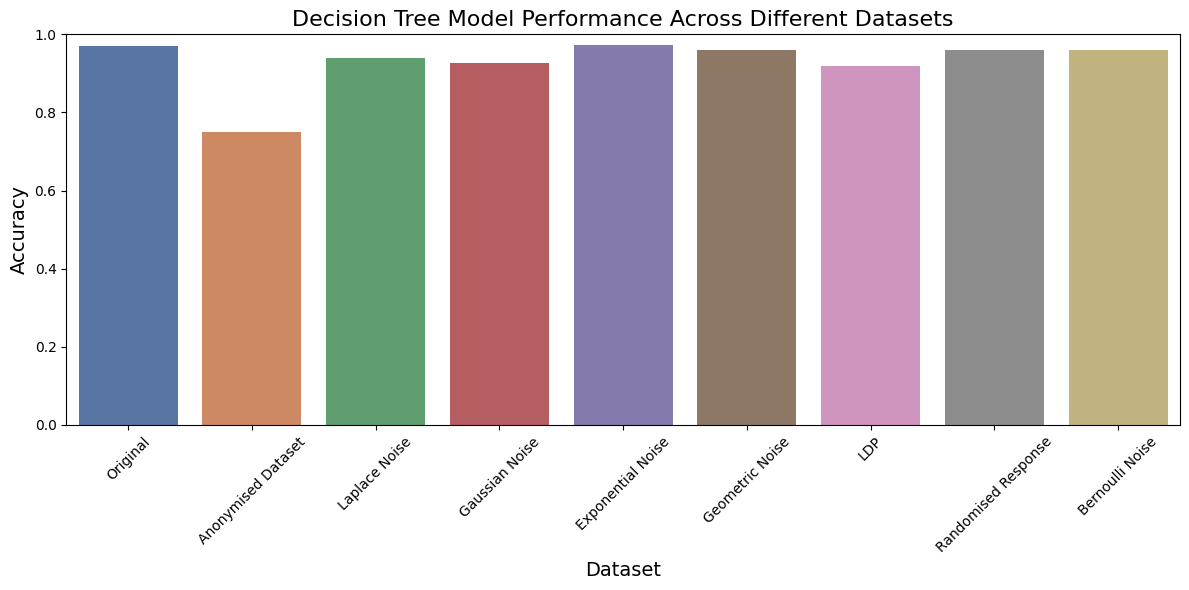

Accuracy  Precision    Recall  F1 Score
Original             0.970149   0.943396  0.909091  0.925926
Anonymised Dataset   0.750000   0.312500  0.181818  0.229885
Laplace Noise        0.940299   0.854545  0.854545  0.854545
Gaussian Noise       0.925373   0.807018  0.836364  0.821429
Exponential Noise    0.973881   0.961538  0.909091  0.934579
Geometric Noise      0.958955   0.854839  0.963636  0.905983
LDP                  0.917910   0.789474  0.818182  0.803571
Randomised Response  0.958955   0.940000  0.854545  0.895238
Bernoulli Noise      0.958955   0.923077  0.872727  0.897196

In [59]:
# Decision Tree Grid Search parameters
dt_param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Perform Grid Search only on the original dataset
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    datasets['Original'][0], datasets['Original'][1], test_size=0.2, stratify=datasets['Original'][1], random_state=42
)
smote = SMOTE(random_state=42)
X_train_smote_orig, y_train_smote_orig = smote.fit_resample(X_train_orig, y_train_orig)

dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
dt_grid.fit(X_train_smote_orig, y_train_smote_orig)
best_params_orig = dt_grid.best_params_

# Store and print the best parameters
print(f"Best parameters from original dataset: {best_params_orig}")

# Initialize dictionaries to store results and classification reports
results_dt = {}
class_reports_dt = {}

# Initialize smote outside the loop
smote = SMOTE(random_state=42)

# Use the best parameters found on the original dataset to train and evaluate models on all datasets
for dataset_name, (X, y) in datasets.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Train Decision Tree with best parameters found on original data
    dt_model = DecisionTreeClassifier(**best_params_orig)
    dt_model.fit(X_train_smote, y_train_smote)
    y_pred_dt = dt_model.predict(X_test)

    # Calculate and store metrics
    results_dt[dataset_name] = {
        'Accuracy': accuracy_score(y_test, y_pred_dt),
        'Precision': precision_score(y_test, y_pred_dt, zero_division=0),
        'Recall': recall_score(y_test, y_pred_dt, zero_division=0),
        'F1 Score': f1_score(y_test, y_pred_dt, zero_division=0)
    }

    # Store and print the classification report
    class_report_dt = classification_report(y_test, y_pred_dt, zero_division=0)
    class_reports_dt[dataset_name] = class_report_dt
    print(f"Classification Report for {dataset_name} (Decision Tree):\n{class_report_dt}\n")

# Visualization of Decision Tree model performance
plt.figure(figsize=(12, 6))
sns.barplot(x=list(results_dt.keys()), y=[metrics['Accuracy'] for metrics in results_dt.values()], palette="deep")
plt.title('Decision Tree Model Performance Across Different Datasets', fontsize=16)
plt.xlabel('Dataset', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a DataFrame from the results
results_df = pd.DataFrame.from_dict(results_dt, orient='index')

# Display the DataFrame
display(results_df)

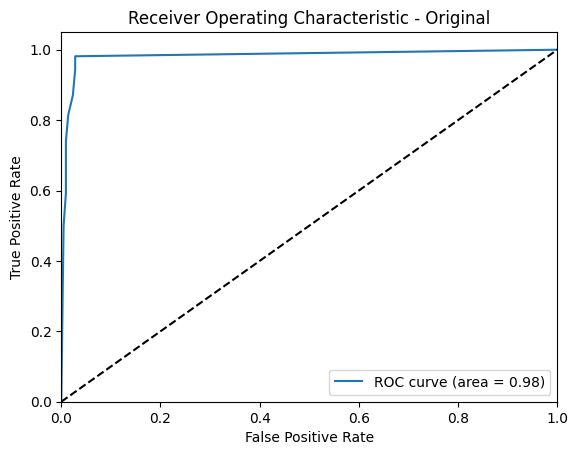

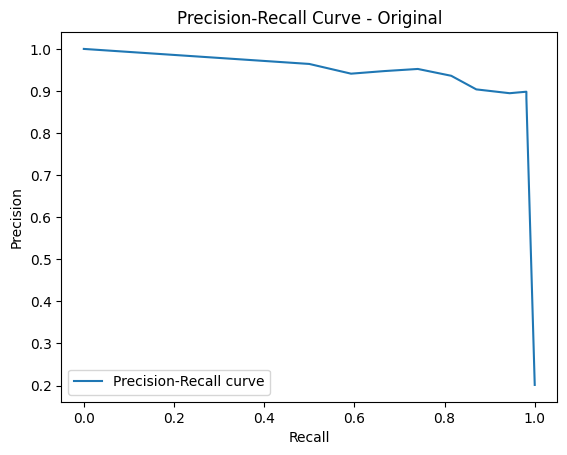

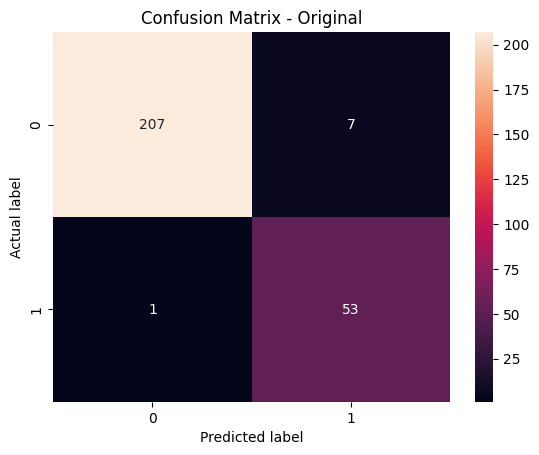

F1-Score for Original: 0.93


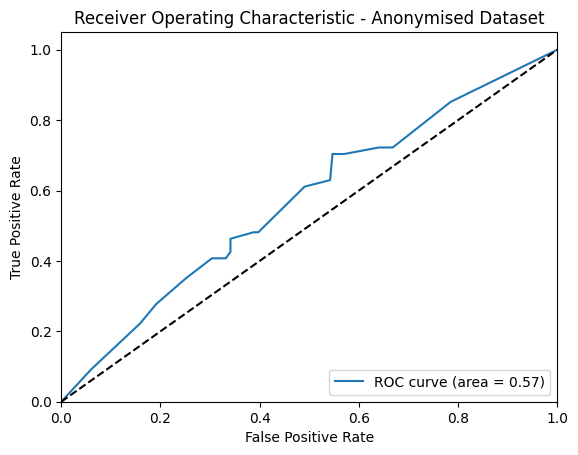

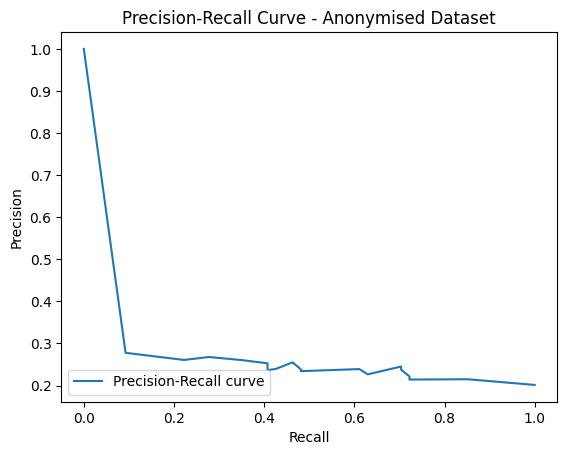

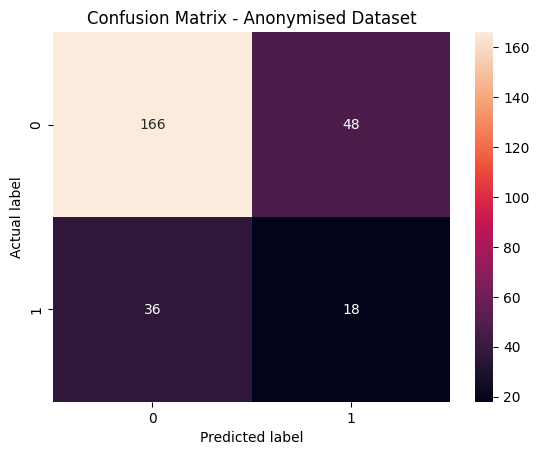

F1-Score for Anonymised Dataset: 0.30


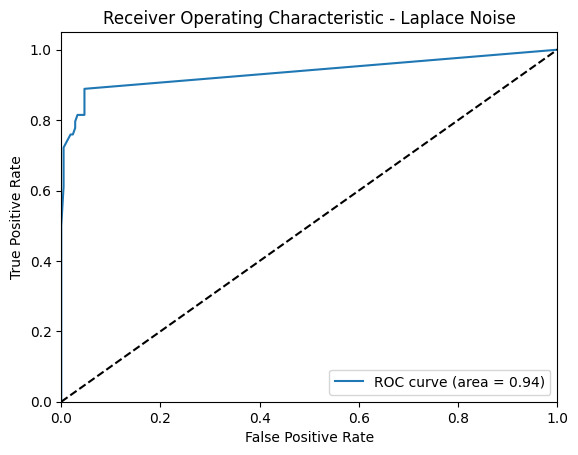

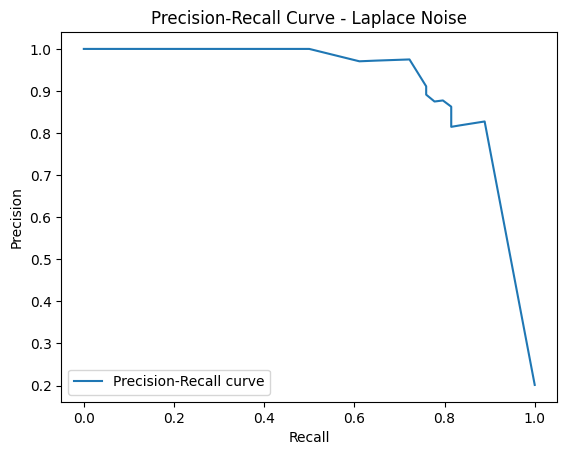

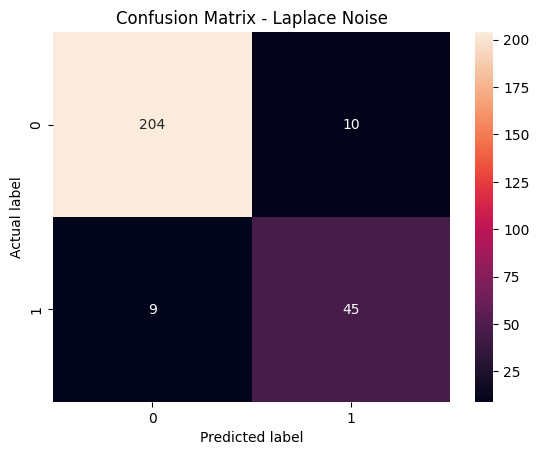

F1-Score for Laplace Noise: 0.83


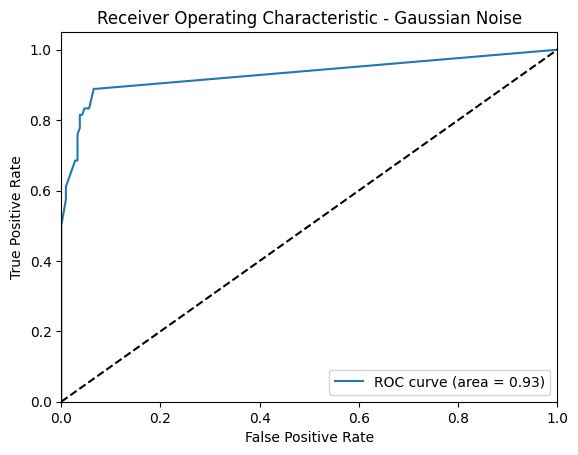

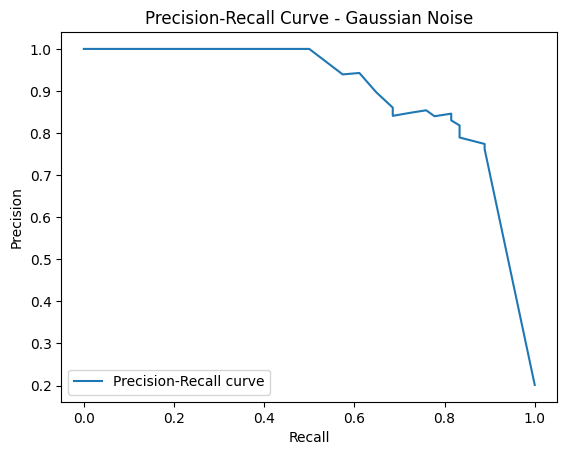

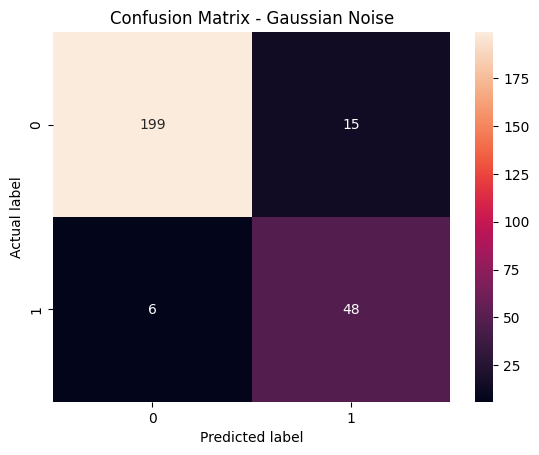

F1-Score for Gaussian Noise: 0.82


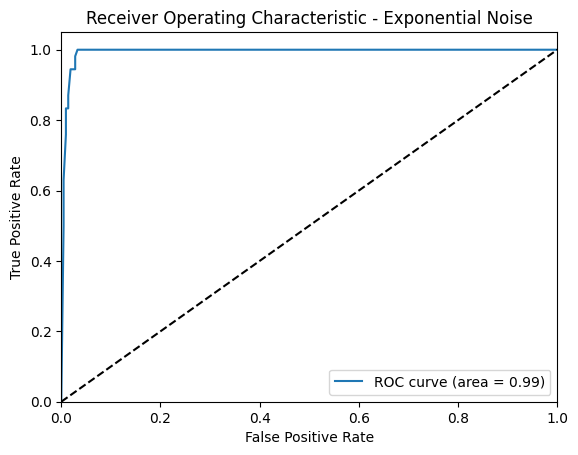

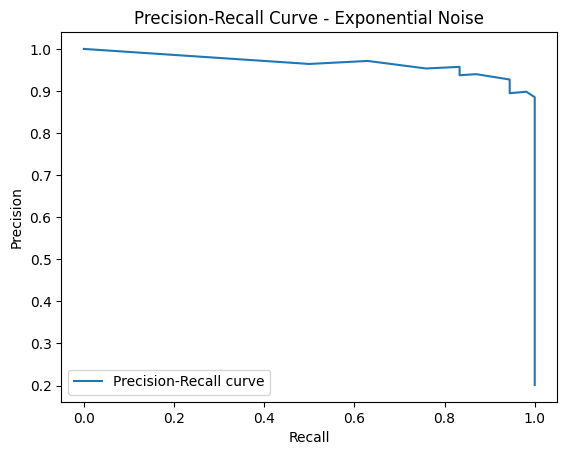

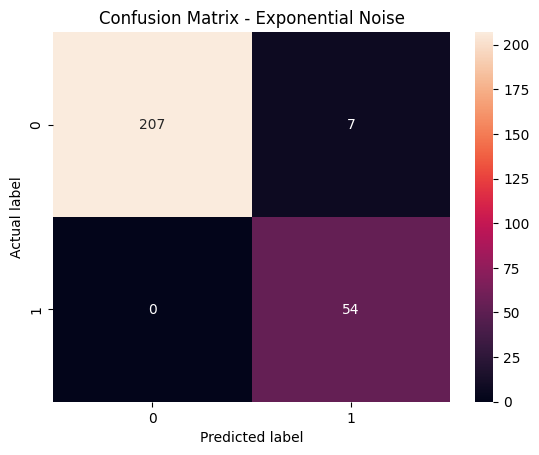

F1-Score for Exponential Noise: 0.94


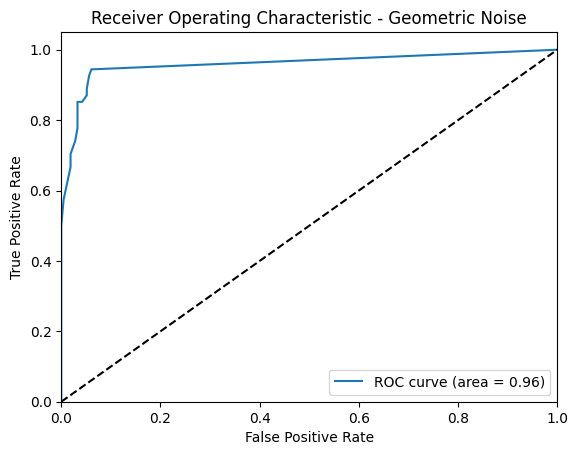

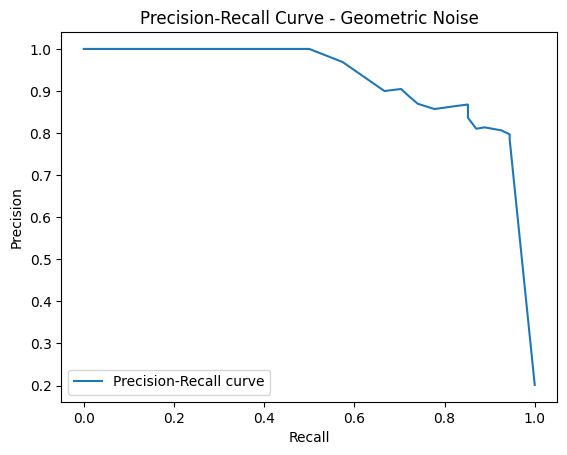

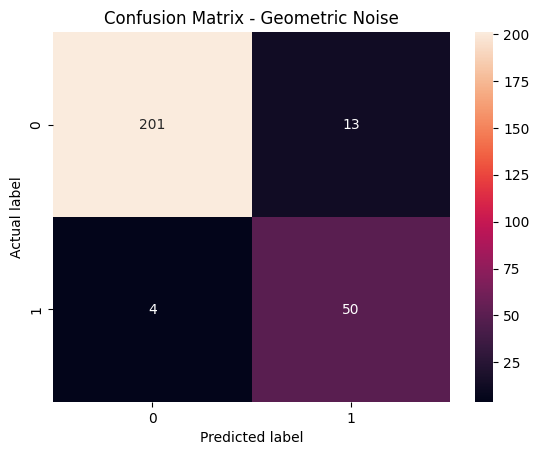

F1-Score for Geometric Noise: 0.85


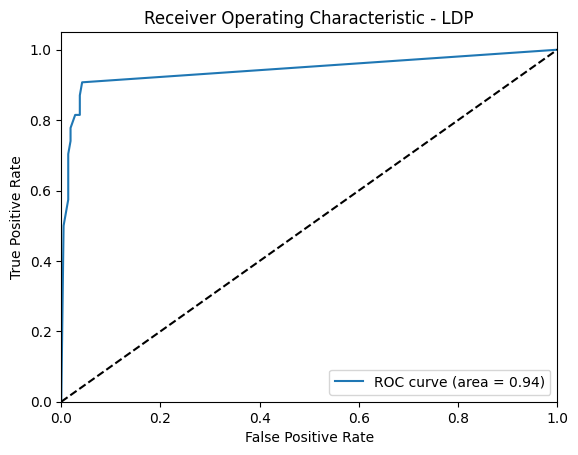

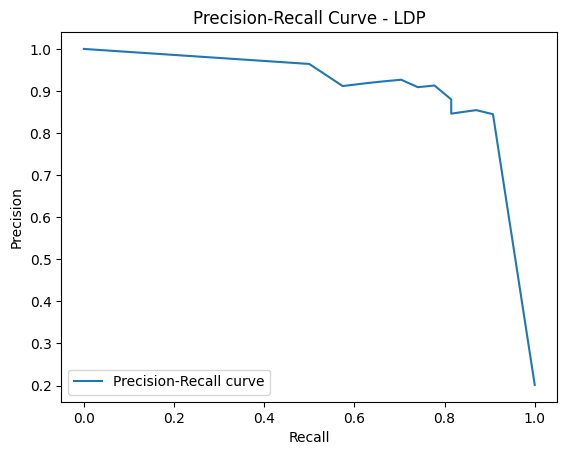

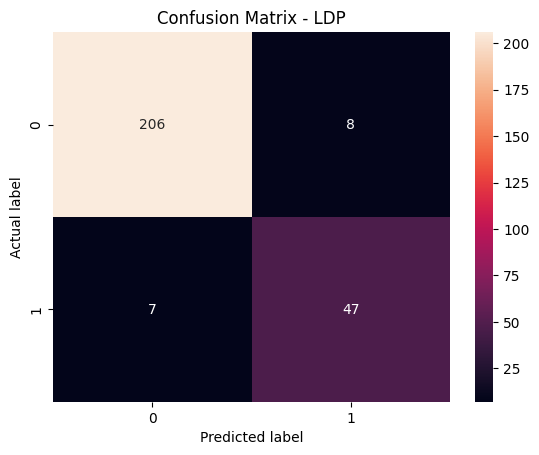

F1-Score for LDP: 0.86


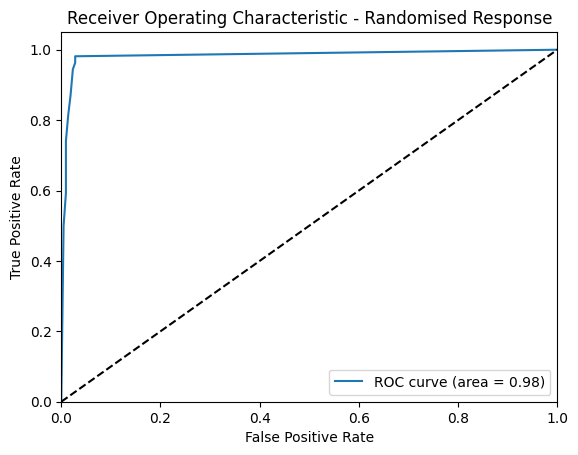

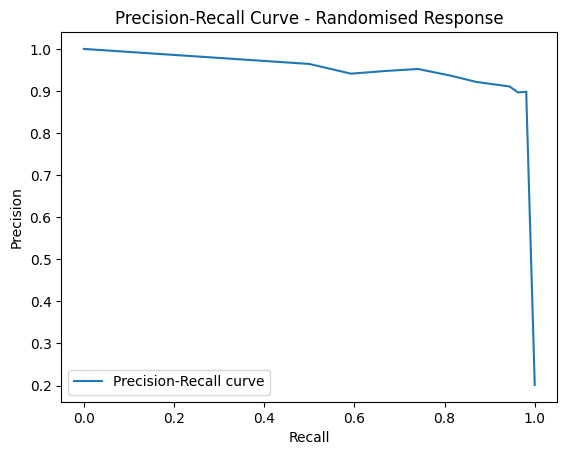

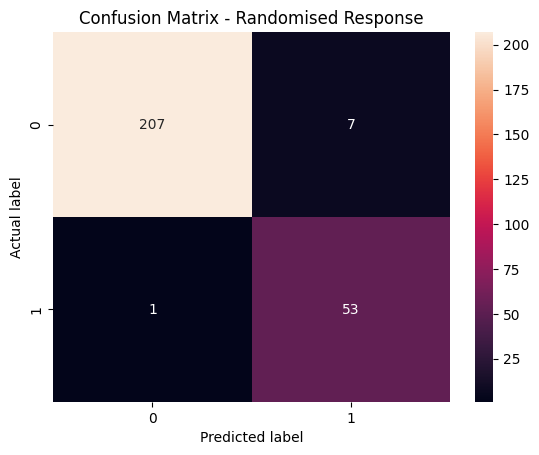

F1-Score for Randomised Response: 0.93


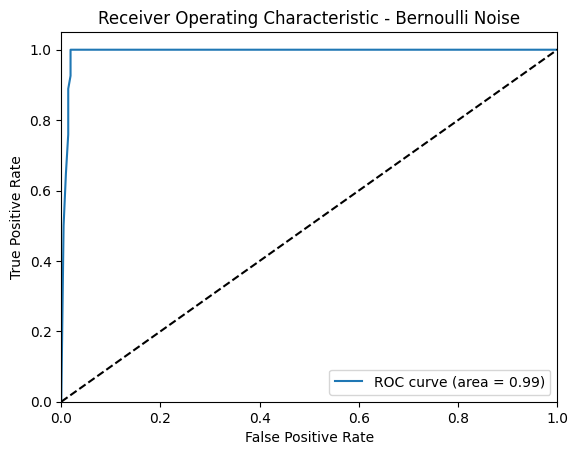

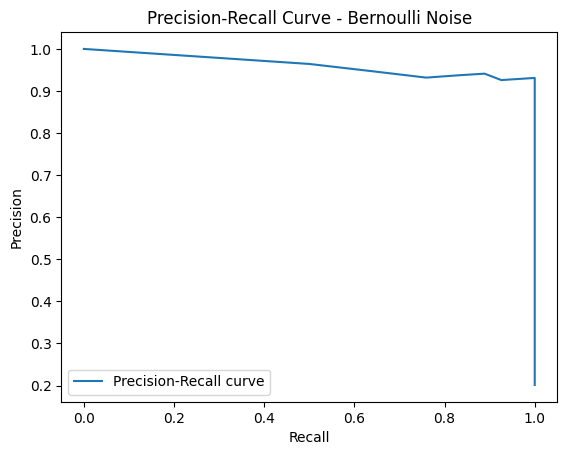

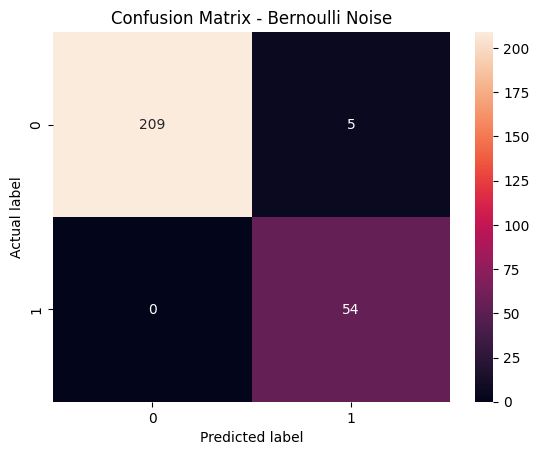

F1-Score for Bernoulli Noise: 0.96


In [47]:
# Function to estimate probabilities based on leaf impurities
def estimate_probabilities(decision_tree, X):
    # Get the leaf indices for each sample in X
    leaf_indices = decision_tree.apply(X)

    # Estimate probabilities based on the proportion of positive samples in each leaf
    return np.array([np.mean(decision_tree.tree_.value[leaf_idx][0][1]) for leaf_idx in leaf_indices])

# Additional Visualisations
results_dt = {}

for dataset_name, (X, y) in datasets.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Train the Decision Tree model
    dt_model = DecisionTreeClassifier(**best_params_dt)
    dt_model.fit(X_train_smote, y_train_smote)

    # Estimate probabilities for positive class
    y_proba = estimate_probabilities(dt_model, X_test)

    results_dt[dataset_name] = {
        "y_true": y_test,
        "y_pred": dt_model.predict(X_test),
        "y_proba": y_proba
    }

for dataset_name, data in results_dt.items():
    y_true, y_pred, y_proba = data["y_true"], data["y_pred"], data["y_proba"]
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    plt.figure()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {dataset_name}')
    plt.legend(loc="lower left")
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    # Additional Metrics
    f1 = f1_score(y_true, y_pred)
    print(f'F1-Score for {dataset_name}: {f1:.2f}')

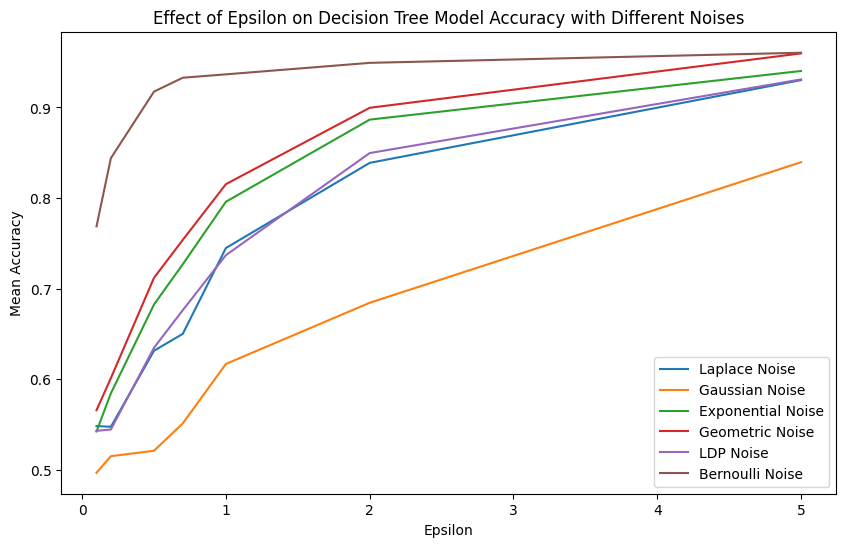

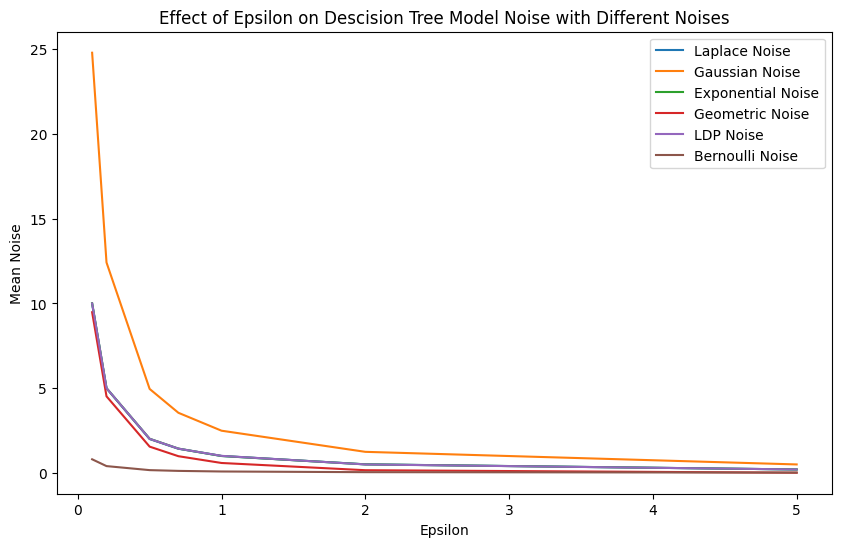

In [55]:
# Function to evaluate the effect of epsilon on accuracy and noise
def evaluate_epsilon_effect(epsilon_values, noise_type, X, y, runs=10):
    mean_accuracies = []
    mean_noises = []
    for epsilon in epsilon_values:
        accuracies = []
        noises = []
        for _ in range(runs):
            X_noisy = None

            if noise_type == 'laplace':
                X_noisy = add_laplace_noise(X, epsilon=epsilon)
            elif noise_type == 'gaussian':
                X_noisy = add_gaussian_noise(X, epsilon=epsilon)
            elif noise_type == 'exponential':
                X_noisy = add_exponential_noise(X, epsilon=epsilon)
            elif noise_type == 'geometric':
                X_noisy = add_geometric_noise(X, epsilon=epsilon)
            elif noise_type == 'ldp':
                X_noisy = add_ldp_noise(X, epsilon=epsilon)
            elif noise_type == 'bernoulli':
                X_noisy = add_bernoulli_noise(X, epsilon=epsilon)

            if X_noisy is None:
                raise ValueError(f"X_noisy is None for noise_type {noise_type} and epsilon {epsilon}")


            # Splitting the dataset into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X_noisy, y, test_size=0.2, random_state=42)

            # Apply SMOTE to the training set
            smote = SMOTE(random_state=42)
            X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

            # Create and train the Decision Tree model
            dt_model = DecisionTreeClassifier(**best_params_dt) 
            dt_model.fit(X_train_smote, y_train_smote)

            # Evaluate the model
            y_pred = dt_model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            accuracies.append(accuracy)

            noise = np.mean(np.abs(X_noisy - X))
            noises.append(noise)

        mean_accuracy = np.mean(accuracies)
        mean_accuracies.append((epsilon, mean_accuracy))
        mean_noise = np.mean(noises)
        mean_noises.append((epsilon, mean_noise))

    return mean_accuracies, mean_noises

# Define a range of epsilon values to test
epsilon_values = [0.1, 0.2, 0.5, 0.7, 1.0, 2.0, 5.0]

# Evaluate the effect of epsilon on accuracy and noise for all noise types
laplace_results, laplace_noises = evaluate_epsilon_effect(epsilon_values, 'laplace', X_original, y_original)
gaussian_results, gaussian_noises = evaluate_epsilon_effect(epsilon_values, 'gaussian', X_original, y_original)
exponential_results, exponential_noises = evaluate_epsilon_effect(epsilon_values, 'exponential', X_original, y_original)
geometric_results, geometric_noises = evaluate_epsilon_effect(epsilon_values, 'geometric', X_original, y_original)
ldp_results, ldp_noises = evaluate_epsilon_effect(epsilon_values, 'ldp', X_original, y_original)
bernoulli_results, bernoulli_noises = evaluate_epsilon_effect(epsilon_values, 'bernoulli', X_original, y_original)

# Plotting the results
plt.figure(figsize=(10, 6))
epsilons, laplace_accuracies = zip(*laplace_results)
plt.plot(epsilons, laplace_accuracies, label='Laplace Noise')

epsilons, gaussian_accuracies = zip(*gaussian_results)
plt.plot(epsilons, gaussian_accuracies, label='Gaussian Noise')

epsilons, exponential_accuracies = zip(*exponential_results)
plt.plot(epsilons, exponential_accuracies, label='Exponential Noise')

epsilons, geometric_accuracies = zip(*geometric_results)
plt.plot(epsilons, geometric_accuracies, label='Geometric Noise')

epsilons, ldp_accuracies = zip(*ldp_results)
plt.plot(epsilons, ldp_accuracies, label='LDP Noise')

epsilons, bernoulli_accuracies = zip(*bernoulli_results)
plt.plot(epsilons, bernoulli_accuracies, label='Bernoulli Noise')

plt.xlabel('Epsilon')
plt.ylabel('Mean Accuracy')
plt.title('Effect of Epsilon on Decision Tree Model Accuracy with Different Noises')
plt.legend()
plt.show()

# Plotting the noise
plt.figure(figsize=(10, 6))
epsilons, laplace_noises = zip(*laplace_noises)
plt.plot(epsilons, laplace_noises, label='Laplace Noise')

epsilons, gaussian_noises = zip(*gaussian_noises)
plt.plot(epsilons, gaussian_noises, label='Gaussian Noise')

epsilons, exponential_noises = zip(*exponential_noises)
plt.plot(epsilons, exponential_noises, label='Exponential Noise')

epsilons, geometric_noises = zip(*geometric_noises)
plt.plot(epsilons, geometric_noises, label='Geometric Noise')

epsilons, ldp_noises = zip(*ldp_noises)
plt.plot(epsilons, ldp_noises, label='LDP Noise')

epsilons, bernoulli_noises = zip(*bernoulli_noises)
plt.plot(epsilons, bernoulli_noises, label='Bernoulli Noise')

plt.xlabel('Epsilon')
plt.ylabel('Mean Noise')
plt.title('Effect of Epsilon on Descision Tree Model Noise with Different Noises')
plt.legend()
plt.show()


In [60]:
# Function to print results in a tabular format
def print_results_table(results, noises, noise_type):
    print(f"\n{noise_type} Noise Results:")
    print("Epsilon\tMean Accuracy\tMean Noise")

    for i in range(len(results)):
        epsilon = results[i][0] if isinstance(results[i], tuple) else results[i]
        accuracy = results[i][1] if isinstance(results[i], tuple) else None
        noise = noises[i][1] if isinstance(noises[i], tuple) else noises[i]

        accuracy_str = f"{accuracy:.2f}" if accuracy is not None else "N/A"
        print(f"{epsilon}\t{accuracy_str}\t{noise:.2f}")

# Extract and print the results for each noise type
print("Results Table for Different Noises:")

# Assuming laplace_results, gaussian_results, etc. are obtained from the evaluate_epsilon_effect function
# Laplace Noise
print_results_table(laplace_results, laplace_noises, 'Laplace')

# Gaussian Noise
print_results_table(gaussian_results, gaussian_noises, 'Gaussian')

# Exponential Noise
print_results_table(exponential_results, exponential_noises, 'Exponential')

# Geometric Noise
print_results_table(geometric_results, geometric_noises, 'Geometric')

# LDP Noise
print_results_table(ldp_results, ldp_noises, 'LDP')

# Bernoulli Noise
print_results_table(bernoulli_results, bernoulli_noises, 'Bernoulli')


Results Table for Different Noises:

Laplace Noise Results:
Epsilon	Mean Accuracy	Mean Noise
0.1	0.55	9.99
0.2	0.55	4.99
0.5	0.63	2.00
0.7	0.65	1.42
1.0	0.74	1.00
2.0	0.84	0.50
5.0	0.93	0.20

Gaussian Noise Results:
Epsilon	Mean Accuracy	Mean Noise
0.1	0.50	24.80
0.2	0.51	12.42
0.5	0.52	4.95
0.7	0.55	3.54
1.0	0.62	2.49
2.0	0.68	1.24
5.0	0.84	0.50

Exponential Noise Results:
Epsilon	Mean Accuracy	Mean Noise
0.1	0.54	10.01
0.2	0.58	5.00
0.5	0.68	2.01
0.7	0.73	1.43
1.0	0.80	0.99
2.0	0.89	0.50
5.0	0.94	0.20

Geometric Noise Results:
Epsilon	Mean Accuracy	Mean Noise
0.1	0.57	9.48
0.2	0.60	4.52
0.5	0.71	1.55
0.7	0.75	0.98
1.0	0.82	0.58
2.0	0.90	0.16
5.0	0.96	0.01

LDP Noise Results:
Epsilon	Mean Accuracy	Mean Noise
0.1	0.54	10.00
0.2	0.54	5.00
0.5	0.63	2.01
0.7	0.68	1.43
1.0	0.74	1.00
2.0	0.85	0.50
5.0	0.93	0.20

Bernoulli Noise Results:
Epsilon	Mean Accuracy	Mean Noise
0.1	0.77	0.80
0.2	0.84	0.40
0.5	0.92	0.16
0.7	0.93	0.12
1.0	0.94	0.08
2.0	0.95	0.04
5.0	0.96	0.02
